# Introduction

This notebook will be used only to analyze data from the third Vanilla execution. The experiment setup is as follows:

1. Execution was done on Comet.
2. The core count was 16,64,256,1024 cores
3. One CU per core
4. The calculation was done over 128 trajectories and the whole matrix was calculated.
5. Each trajectory file has 102 frames of 214 atoms each.

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas

In [3]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [4]:
def SparkLogToDataFrame(filename,path):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((8,1),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0] = int(stat['Task Info']['Task ID'])
            data_point[1] = int(stat['Task Info']['Launch Time'])
            data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[6] = int(stat['Task Info']['Finish Time'])
            data_point[7] = int(stat['Task Metrics']['Result Size'])
            data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
            data_case = pandas.DataFrame(data_point.reshape((1,8)),columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [5]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/unit.000000/' + appName
        print appPath
        timings = np.load(path + sessionName + '/unit.000000/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [6]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# 1. Vanilla Experiments

## 1.1 Setting up everything

In [29]:
rp_haus_16_32_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_short_ca_1.csv',index_col=None)
rp_haus_16_32_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_short_ca_2.csv',index_col=None)
rp_haus_16_32_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_short_ca_3.csv',index_col=None)
rp_haus_64_16_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_short_ca_1.csv',index_col=None)
rp_haus_64_16_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_short_ca_2.csv',index_col=None)
rp_haus_64_16_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_short_ca_3.csv',index_col=None)
rp_haus_256_8_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_short_ca_1.csv',index_col=None)
rp_haus_256_8_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_short_ca_2.csv',index_col=None)
rp_haus_256_8_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_short_ca_3.csv',index_col=None)
rp_haus_1024_4_short_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_short_ca_1.csv',index_col=None)
rp_haus_1024_4_short_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_short_ca_2.csv',index_col=None)
rp_haus_1024_4_short_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_short_ca_3.csv',index_col=None)

rp_haus_16_32_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_med_ca_1.csv',index_col=None)
rp_haus_16_32_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_med_ca_2.csv',index_col=None)
rp_haus_16_32_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_med_ca_3.csv',index_col=None)
rp_haus_64_16_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_med_ca_1.csv',index_col=None)
rp_haus_64_16_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_med_ca_2.csv',index_col=None)
rp_haus_64_16_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_med_ca_3.csv',index_col=None)
rp_haus_256_8_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_med_ca_1.csv',index_col=None)
rp_haus_256_8_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_med_ca_2.csv',index_col=None)
rp_haus_256_8_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_med_ca_3.csv',index_col=None)
rp_haus_1024_4_med_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_med_ca_1.csv',index_col=None)
rp_haus_1024_4_med_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_med_ca_2.csv',index_col=None)
rp_haus_1024_4_med_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_med_ca_3.csv',index_col=None)

rp_haus_16_32_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_long_ca_1.csv',index_col=None)
rp_haus_16_32_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_long_ca_2.csv',index_col=None)
rp_haus_16_32_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_16_32_long_ca_3.csv',index_col=None)
rp_haus_64_16_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_long_ca_1.csv',index_col=None)
rp_haus_64_16_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_long_ca_2.csv',index_col=None)
rp_haus_64_16_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_64_16_long_ca_3.csv',index_col=None)
rp_haus_256_8_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_long_ca_1.csv',index_col=None)
rp_haus_256_8_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_long_ca_2.csv',index_col=None)
rp_haus_256_8_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_256_8_long_ca_3.csv',index_col=None)
rp_haus_1024_4_long_ca_1 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_long_ca_1.csv',index_col=None)
rp_haus_1024_4_long_ca_2 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_long_ca_2.csv',index_col=None)
rp_haus_1024_4_long_ca_3 = pandas.DataFrame.from_csv('Vanilla/Comet/Iter3/rpco_haus_1024_4_long_ca_3.csv',index_col=None)


In [30]:
rp_haus_16_32_short_ca_tmp = pandas.concat([rp_haus_16_32_short_ca_1,rp_haus_16_32_short_ca_2,rp_haus_16_32_short_ca_3],ignore_index=True)
rp_haus_64_16_short_ca_tmp = pandas.concat([rp_haus_64_16_short_ca_1,rp_haus_64_16_short_ca_2,rp_haus_64_16_short_ca_3],ignore_index=True)
rp_haus_256_8_short_ca_tmp = pandas.concat([rp_haus_256_8_short_ca_1,rp_haus_256_8_short_ca_2,rp_haus_256_8_short_ca_3],ignore_index=True)
rp_haus_1024_4_short_ca_tmp = pandas.concat([rp_haus_1024_4_short_ca_1,rp_haus_1024_4_short_ca_2,rp_haus_1024_4_short_ca_3],ignore_index=True)

rp_haus_16_32_med_ca_tmp = pandas.concat([rp_haus_16_32_med_ca_1,rp_haus_16_32_med_ca_2,rp_haus_16_32_med_ca_3],ignore_index=True)
rp_haus_64_16_med_ca_tmp = pandas.concat([rp_haus_64_16_med_ca_1,rp_haus_64_16_med_ca_2,rp_haus_64_16_med_ca_3],ignore_index=True)
rp_haus_256_8_med_ca_tmp = pandas.concat([rp_haus_256_8_med_ca_1,rp_haus_256_8_med_ca_2,rp_haus_256_8_med_ca_3],ignore_index=True)
rp_haus_1024_4_med_ca_tmp = pandas.concat([rp_haus_1024_4_med_ca_1,rp_haus_1024_4_med_ca_2,rp_haus_1024_4_med_ca_3],ignore_index=True)

rp_haus_16_32_long_ca_tmp = pandas.concat([rp_haus_16_32_long_ca_1,rp_haus_16_32_long_ca_2,rp_haus_16_32_long_ca_3],ignore_index=True)
rp_haus_64_16_long_ca_tmp = pandas.concat([rp_haus_64_16_long_ca_1,rp_haus_64_16_long_ca_2,rp_haus_64_16_long_ca_3],ignore_index=True)
rp_haus_256_8_long_ca_tmp = pandas.concat([rp_haus_256_8_long_ca_1,rp_haus_256_8_long_ca_2,rp_haus_256_8_long_ca_3],ignore_index=True)
rp_haus_1024_4_long_ca_tmp = pandas.concat([rp_haus_1024_4_long_ca_1,rp_haus_1024_4_long_ca_2,rp_haus_1024_4_long_ca_3],ignore_index=True)

In [31]:
tidy_rpvanilla_haus = pandas.DataFrame(columns=['Atom','Length','Run','Cores','StageInPending','StageInPendingStd','StageInDelay','StageInDelayStd','SchedulerDelay','SchedulerDelayStd','Execution','ExecutionStd','StageOut','StageOutStd','TotalTime','TotalTimeStd'])
data=[(rp_haus_16_32_short_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_1['StageIn']).std(),\
      (rp_haus_16_32_short_ca_1['Allocate']-rp_haus_16_32_short_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_1['Allocate']-rp_haus_16_32_short_ca_1['StageIn']).std(),\
      (rp_haus_16_32_short_ca_1['Exec']-    rp_haus_16_32_short_ca_1['Allocate']).mean(),\
      (rp_haus_16_32_short_ca_1['Exec']-    rp_haus_16_32_short_ca_1['Allocate']).std(),\
      (rp_haus_16_32_short_ca_1['StageOut']-rp_haus_16_32_short_ca_1['Exec']).mean(),\
      (rp_haus_16_32_short_ca_1['StageOut']-rp_haus_16_32_short_ca_1['Exec']).std(),\
      (rp_haus_16_32_short_ca_1['Done']-    rp_haus_16_32_short_ca_1['StageOut']).mean(),\
      (rp_haus_16_32_short_ca_1['Done']-    rp_haus_16_32_short_ca_1['StageOut']).std(),\
      (rp_haus_16_32_short_ca_1['StageOut']-rp_haus_16_32_short_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_1['StageOut']-rp_haus_16_32_short_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[0] = ['CA','Short',1,16]+data
data=[(rp_haus_16_32_short_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_2['StageIn']).std(),\
      (rp_haus_16_32_short_ca_2['Allocate']-rp_haus_16_32_short_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_2['Allocate']-rp_haus_16_32_short_ca_2['StageIn']).std(),\
      (rp_haus_16_32_short_ca_2['Exec']-    rp_haus_16_32_short_ca_2['Allocate']).mean(),\
      (rp_haus_16_32_short_ca_2['Exec']-    rp_haus_16_32_short_ca_2['Allocate']).std(),\
      (rp_haus_16_32_short_ca_2['StageOut']-rp_haus_16_32_short_ca_2['Exec']).mean(),\
      (rp_haus_16_32_short_ca_2['StageOut']-rp_haus_16_32_short_ca_2['Exec']).std(),\
      (rp_haus_16_32_short_ca_2['Done']-    rp_haus_16_32_short_ca_2['StageOut']).mean(),\
      (rp_haus_16_32_short_ca_2['Done']-    rp_haus_16_32_short_ca_2['StageOut']).std(),\
      (rp_haus_16_32_short_ca_2['StageOut']-rp_haus_16_32_short_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_2['StageOut']-rp_haus_16_32_short_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[1] = ['CA','Short',2,16]+data
data=[(rp_haus_16_32_short_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_3['StageIn']).std(),\
      (rp_haus_16_32_short_ca_3['Allocate']-rp_haus_16_32_short_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_3['Allocate']-rp_haus_16_32_short_ca_3['StageIn']).std(),\
      (rp_haus_16_32_short_ca_3['Exec']-    rp_haus_16_32_short_ca_3['Allocate']).mean(),\
      (rp_haus_16_32_short_ca_3['Exec']-    rp_haus_16_32_short_ca_3['Allocate']).std(),\
      (rp_haus_16_32_short_ca_3['StageOut']-rp_haus_16_32_short_ca_3['Exec']).mean(),\
      (rp_haus_16_32_short_ca_3['StageOut']-rp_haus_16_32_short_ca_3['Exec']).std(),\
      (rp_haus_16_32_short_ca_3['Done']-    rp_haus_16_32_short_ca_3['StageOut']).mean(),\
      (rp_haus_16_32_short_ca_3['Done']-    rp_haus_16_32_short_ca_3['StageOut']).std(),\
      (rp_haus_16_32_short_ca_3['StageOut']-rp_haus_16_32_short_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_short_ca_3['StageOut']-rp_haus_16_32_short_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[2] = ['CA','Short',3,16]+data
data=[(rp_haus_64_16_short_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_1['StageIn']).std(),\
      (rp_haus_64_16_short_ca_1['Allocate']-rp_haus_64_16_short_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_1['Allocate']-rp_haus_64_16_short_ca_1['StageIn']).std(),\
      (rp_haus_64_16_short_ca_1['Exec']-    rp_haus_64_16_short_ca_1['Allocate']).mean(),\
      (rp_haus_64_16_short_ca_1['Exec']-    rp_haus_64_16_short_ca_1['Allocate']).std(),\
      (rp_haus_64_16_short_ca_1['StageOut']-rp_haus_64_16_short_ca_1['Exec']).mean(),\
      (rp_haus_64_16_short_ca_1['StageOut']-rp_haus_64_16_short_ca_1['Exec']).std(),\
      (rp_haus_64_16_short_ca_1['Done']-    rp_haus_64_16_short_ca_1['StageOut']).mean(),\
      (rp_haus_64_16_short_ca_1['Done']-    rp_haus_64_16_short_ca_1['StageOut']).std(),\
      (rp_haus_64_16_short_ca_1['StageOut']-rp_haus_64_16_short_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_1['StageOut']-rp_haus_64_16_short_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[3] = ['CA','Short',1,64]+data
data=[(rp_haus_64_16_short_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_2['StageIn']).std(),\
      (rp_haus_64_16_short_ca_2['Allocate']-rp_haus_64_16_short_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_2['Allocate']-rp_haus_64_16_short_ca_2['StageIn']).std(),\
      (rp_haus_64_16_short_ca_2['Exec']-    rp_haus_64_16_short_ca_2['Allocate']).mean(),\
      (rp_haus_64_16_short_ca_2['Exec']-    rp_haus_64_16_short_ca_2['Allocate']).std(),\
      (rp_haus_64_16_short_ca_2['StageOut']-rp_haus_64_16_short_ca_2['Exec']).mean(),\
      (rp_haus_64_16_short_ca_2['StageOut']-rp_haus_64_16_short_ca_2['Exec']).std(),\
      (rp_haus_64_16_short_ca_2['Done']-    rp_haus_64_16_short_ca_2['StageOut']).mean(),\
      (rp_haus_64_16_short_ca_2['Done']-    rp_haus_64_16_short_ca_2['StageOut']).std(),\
      (rp_haus_64_16_short_ca_2['StageOut']-rp_haus_64_16_short_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_2['StageOut']-rp_haus_64_16_short_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[4] = ['CA','Short',2,64]+data
data=[(rp_haus_64_16_short_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_3['StageIn']).std(),\
      (rp_haus_64_16_short_ca_3['Allocate']-rp_haus_64_16_short_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_3['Allocate']-rp_haus_64_16_short_ca_3['StageIn']).std(),\
      (rp_haus_64_16_short_ca_3['Exec']-    rp_haus_64_16_short_ca_3['Allocate']).mean(),\
      (rp_haus_64_16_short_ca_3['Exec']-    rp_haus_64_16_short_ca_3['Allocate']).std(),\
      (rp_haus_64_16_short_ca_3['StageOut']-rp_haus_64_16_short_ca_3['Exec']).mean(),\
      (rp_haus_64_16_short_ca_3['StageOut']-rp_haus_64_16_short_ca_3['Exec']).std(),\
      (rp_haus_64_16_short_ca_3['Done']-    rp_haus_64_16_short_ca_3['StageOut']).mean(),\
      (rp_haus_64_16_short_ca_3['Done']-    rp_haus_64_16_short_ca_3['StageOut']).std(),\
      (rp_haus_64_16_short_ca_3['StageOut']-rp_haus_64_16_short_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_short_ca_3['StageOut']-rp_haus_64_16_short_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[5] = ['CA','Short',3,64]+data
data=[(rp_haus_256_8_short_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_1['StageIn']).std(),\
      (rp_haus_256_8_short_ca_1['Allocate']-rp_haus_256_8_short_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_1['Allocate']-rp_haus_256_8_short_ca_1['StageIn']).std(),\
      (rp_haus_256_8_short_ca_1['Exec']-    rp_haus_256_8_short_ca_1['Allocate']).mean(),\
      (rp_haus_256_8_short_ca_1['Exec']-    rp_haus_256_8_short_ca_1['Allocate']).std(),\
      (rp_haus_256_8_short_ca_1['StageOut']-rp_haus_256_8_short_ca_1['Exec']).mean(),\
      (rp_haus_256_8_short_ca_1['StageOut']-rp_haus_256_8_short_ca_1['Exec']).std(),\
      (rp_haus_256_8_short_ca_1['Done']-    rp_haus_256_8_short_ca_1['StageOut']).mean(),\
      (rp_haus_256_8_short_ca_1['Done']-    rp_haus_256_8_short_ca_1['StageOut']).std(),\
      (rp_haus_256_8_short_ca_1['StageOut']-rp_haus_256_8_short_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_1['StageOut']-rp_haus_256_8_short_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[6] = ['CA','Short',1,256]+data
data=[(rp_haus_256_8_short_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_2['StageIn']).std(),\
      (rp_haus_256_8_short_ca_2['Allocate']-rp_haus_256_8_short_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_2['Allocate']-rp_haus_256_8_short_ca_2['StageIn']).std(),\
      (rp_haus_256_8_short_ca_2['Exec']-    rp_haus_256_8_short_ca_2['Allocate']).mean(),\
      (rp_haus_256_8_short_ca_2['Exec']-    rp_haus_256_8_short_ca_2['Allocate']).std(),\
      (rp_haus_256_8_short_ca_2['StageOut']-rp_haus_256_8_short_ca_2['Exec']).mean(),\
      (rp_haus_256_8_short_ca_2['StageOut']-rp_haus_256_8_short_ca_2['Exec']).std(),\
      (rp_haus_256_8_short_ca_2['Done']-    rp_haus_256_8_short_ca_2['StageOut']).mean(),\
      (rp_haus_256_8_short_ca_2['Done']-    rp_haus_256_8_short_ca_2['StageOut']).std(),\
      (rp_haus_256_8_short_ca_2['StageOut']-rp_haus_256_8_short_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_2['StageOut']-rp_haus_256_8_short_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[7] = ['CA','Short',2,256]+data
data=[(rp_haus_256_8_short_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_3['StageIn']).std(),\
      (rp_haus_256_8_short_ca_3['Allocate']-rp_haus_256_8_short_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_3['Allocate']-rp_haus_256_8_short_ca_3['StageIn']).std(),\
      (rp_haus_256_8_short_ca_3['Exec']-    rp_haus_256_8_short_ca_3['Allocate']).mean(),\
      (rp_haus_256_8_short_ca_3['Exec']-    rp_haus_256_8_short_ca_3['Allocate']).std(),\
      (rp_haus_256_8_short_ca_3['StageOut']-rp_haus_256_8_short_ca_3['Exec']).mean(),\
      (rp_haus_256_8_short_ca_3['StageOut']-rp_haus_256_8_short_ca_3['Exec']).std(),\
      (rp_haus_256_8_short_ca_3['Done']-    rp_haus_256_8_short_ca_3['StageOut']).mean(),\
      (rp_haus_256_8_short_ca_3['Done']-    rp_haus_256_8_short_ca_3['StageOut']).std(),\
      (rp_haus_256_8_short_ca_3['StageOut']-rp_haus_256_8_short_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_short_ca_3['StageOut']-rp_haus_256_8_short_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[8] = ['CA','Short',3,256]+data
data=[(rp_haus_1024_4_short_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_1['Allocate']-rp_haus_1024_4_short_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_1['Allocate']-rp_haus_1024_4_short_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_1['Exec']-    rp_haus_1024_4_short_ca_1['Allocate']).mean(),\
      (rp_haus_1024_4_short_ca_1['Exec']-    rp_haus_1024_4_short_ca_1['Allocate']).std(),\
      (rp_haus_1024_4_short_ca_1['StageOut']-rp_haus_1024_4_short_ca_1['Exec']).mean(),\
      (rp_haus_1024_4_short_ca_1['StageOut']-rp_haus_1024_4_short_ca_1['Exec']).std(),\
      (rp_haus_1024_4_short_ca_1['Done']-    rp_haus_1024_4_short_ca_1['StageOut']).mean(),\
      (rp_haus_1024_4_short_ca_1['Done']-    rp_haus_1024_4_short_ca_1['StageOut']).std(),\
      (rp_haus_1024_4_short_ca_1['StageOut']-rp_haus_1024_4_short_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_1['StageOut']-rp_haus_1024_4_short_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[9] = ['CA','Short',1,1024]+data
data=[(rp_haus_1024_4_short_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_2['Allocate']-rp_haus_1024_4_short_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_2['Allocate']-rp_haus_1024_4_short_ca_2['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_2['Exec']-    rp_haus_1024_4_short_ca_2['Allocate']).mean(),\
      (rp_haus_1024_4_short_ca_2['Exec']-    rp_haus_1024_4_short_ca_2['Allocate']).std(),\
      (rp_haus_1024_4_short_ca_2['StageOut']-rp_haus_1024_4_short_ca_2['Exec']).mean(),\
      (rp_haus_1024_4_short_ca_2['StageOut']-rp_haus_1024_4_short_ca_2['Exec']).std(),\
      (rp_haus_1024_4_short_ca_2['Done']-    rp_haus_1024_4_short_ca_2['StageOut']).mean(),\
      (rp_haus_1024_4_short_ca_2['Done']-    rp_haus_1024_4_short_ca_2['StageOut']).std(),\
      (rp_haus_1024_4_short_ca_2['StageOut']-rp_haus_1024_4_short_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_2['StageOut']-rp_haus_1024_4_short_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[10] = ['CA','Short',2,1024]+data
data=[(rp_haus_1024_4_short_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_3['Allocate']-rp_haus_1024_4_short_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_3['Allocate']-rp_haus_1024_4_short_ca_3['StageIn']).std(),\
      (rp_haus_1024_4_short_ca_3['Exec']-    rp_haus_1024_4_short_ca_3['Allocate']).mean(),\
      (rp_haus_1024_4_short_ca_3['Exec']-    rp_haus_1024_4_short_ca_3['Allocate']).std(),\
      (rp_haus_1024_4_short_ca_3['StageOut']-rp_haus_1024_4_short_ca_3['Exec']).mean(),\
      (rp_haus_1024_4_short_ca_3['StageOut']-rp_haus_1024_4_short_ca_3['Exec']).std(),\
      (rp_haus_1024_4_short_ca_3['Done']-    rp_haus_1024_4_short_ca_3['StageOut']).mean(),\
      (rp_haus_1024_4_short_ca_3['Done']-    rp_haus_1024_4_short_ca_3['StageOut']).std(),\
      (rp_haus_1024_4_short_ca_3['StageOut']-rp_haus_1024_4_short_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_short_ca_3['StageOut']-rp_haus_1024_4_short_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[11] = ['CA','Short',3,1024]+data
data=[(rp_haus_16_32_med_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_1['StageIn']).std(),\
      (rp_haus_16_32_med_ca_1['Allocate']-rp_haus_16_32_med_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_1['Allocate']-rp_haus_16_32_med_ca_1['StageIn']).std(),\
      (rp_haus_16_32_med_ca_1['Exec']-    rp_haus_16_32_med_ca_1['Allocate']).mean(),\
      (rp_haus_16_32_med_ca_1['Exec']-    rp_haus_16_32_med_ca_1['Allocate']).std(),\
      (rp_haus_16_32_med_ca_1['StageOut']-rp_haus_16_32_med_ca_1['Exec']).mean(),\
      (rp_haus_16_32_med_ca_1['StageOut']-rp_haus_16_32_med_ca_1['Exec']).std(),\
      (rp_haus_16_32_med_ca_1['Done']-    rp_haus_16_32_med_ca_1['StageOut']).mean(),\
      (rp_haus_16_32_med_ca_1['Done']-    rp_haus_16_32_med_ca_1['StageOut']).std(),\
      (rp_haus_16_32_med_ca_1['StageOut']-rp_haus_16_32_med_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_1['StageOut']-rp_haus_16_32_med_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[12] = ['CA','Med',1,16]+data
data=[(rp_haus_16_32_med_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_2['StageIn']).std(),\
      (rp_haus_16_32_med_ca_2['Allocate']-rp_haus_16_32_med_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_2['Allocate']-rp_haus_16_32_med_ca_2['StageIn']).std(),\
      (rp_haus_16_32_med_ca_2['Exec']-    rp_haus_16_32_med_ca_2['Allocate']).mean(),\
      (rp_haus_16_32_med_ca_2['Exec']-    rp_haus_16_32_med_ca_2['Allocate']).std(),\
      (rp_haus_16_32_med_ca_2['StageOut']-rp_haus_16_32_med_ca_2['Exec']).mean(),\
      (rp_haus_16_32_med_ca_2['StageOut']-rp_haus_16_32_med_ca_2['Exec']).std(),\
      (rp_haus_16_32_med_ca_2['Done']-    rp_haus_16_32_med_ca_2['StageOut']).mean(),\
      (rp_haus_16_32_med_ca_2['Done']-    rp_haus_16_32_med_ca_2['StageOut']).std(),\
      (rp_haus_16_32_med_ca_2['StageOut']-rp_haus_16_32_med_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_2['StageOut']-rp_haus_16_32_med_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[13] = ['CA','Med',2,16]+data
data=[(rp_haus_16_32_med_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_3['StageIn']).std(),\
      (rp_haus_16_32_med_ca_3['Allocate']-rp_haus_16_32_med_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_3['Allocate']-rp_haus_16_32_med_ca_3['StageIn']).std(),\
      (rp_haus_16_32_med_ca_3['Exec']-    rp_haus_16_32_med_ca_3['Allocate']).mean(),\
      (rp_haus_16_32_med_ca_3['Exec']-    rp_haus_16_32_med_ca_3['Allocate']).std(),\
      (rp_haus_16_32_med_ca_3['StageOut']-rp_haus_16_32_med_ca_3['Exec']).mean(),\
      (rp_haus_16_32_med_ca_3['StageOut']-rp_haus_16_32_med_ca_3['Exec']).std(),\
      (rp_haus_16_32_med_ca_3['Done']-    rp_haus_16_32_med_ca_3['StageOut']).mean(),\
      (rp_haus_16_32_med_ca_3['Done']-    rp_haus_16_32_med_ca_3['StageOut']).std(),\
      (rp_haus_16_32_med_ca_3['StageOut']-rp_haus_16_32_med_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_med_ca_3['StageOut']-rp_haus_16_32_med_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[14] = ['CA','Med',3,16]+data
data=[(rp_haus_64_16_med_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_1['StageIn']).std(),\
      (rp_haus_64_16_med_ca_1['Allocate']-rp_haus_64_16_med_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_1['Allocate']-rp_haus_64_16_med_ca_1['StageIn']).std(),\
      (rp_haus_64_16_med_ca_1['Exec']-    rp_haus_64_16_med_ca_1['Allocate']).mean(),\
      (rp_haus_64_16_med_ca_1['Exec']-    rp_haus_64_16_med_ca_1['Allocate']).std(),\
      (rp_haus_64_16_med_ca_1['StageOut']-rp_haus_64_16_med_ca_1['Exec']).mean(),\
      (rp_haus_64_16_med_ca_1['StageOut']-rp_haus_64_16_med_ca_1['Exec']).std(),\
      (rp_haus_64_16_med_ca_1['Done']-    rp_haus_64_16_med_ca_1['StageOut']).mean(),\
      (rp_haus_64_16_med_ca_1['Done']-    rp_haus_64_16_med_ca_1['StageOut']).std(),\
      (rp_haus_64_16_med_ca_1['StageOut']-rp_haus_64_16_med_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_1['StageOut']-rp_haus_64_16_med_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[15] = ['CA','Med',1,64]+data
data=[(rp_haus_64_16_med_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_2['StageIn']).std(),\
      (rp_haus_64_16_med_ca_2['Allocate']-rp_haus_64_16_med_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_2['Allocate']-rp_haus_64_16_med_ca_2['StageIn']).std(),\
      (rp_haus_64_16_med_ca_2['Exec']-    rp_haus_64_16_med_ca_2['Allocate']).mean(),\
      (rp_haus_64_16_med_ca_2['Exec']-    rp_haus_64_16_med_ca_2['Allocate']).std(),\
      (rp_haus_64_16_med_ca_2['StageOut']-rp_haus_64_16_med_ca_2['Exec']).mean(),\
      (rp_haus_64_16_med_ca_2['StageOut']-rp_haus_64_16_med_ca_2['Exec']).std(),\
      (rp_haus_64_16_med_ca_2['Done']-    rp_haus_64_16_med_ca_2['StageOut']).mean(),\
      (rp_haus_64_16_med_ca_2['Done']-    rp_haus_64_16_med_ca_2['StageOut']).std(),\
      (rp_haus_64_16_med_ca_2['StageOut']-rp_haus_64_16_med_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_2['StageOut']-rp_haus_64_16_med_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[16] = ['CA','Med',2,64]+data
data=[(rp_haus_64_16_med_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_3['StageIn']).std(),\
      (rp_haus_64_16_med_ca_3['Allocate']-rp_haus_64_16_med_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_3['Allocate']-rp_haus_64_16_med_ca_3['StageIn']).std(),\
      (rp_haus_64_16_med_ca_3['Exec']-    rp_haus_64_16_med_ca_3['Allocate']).mean(),\
      (rp_haus_64_16_med_ca_3['Exec']-    rp_haus_64_16_med_ca_3['Allocate']).std(),\
      (rp_haus_64_16_med_ca_3['StageOut']-rp_haus_64_16_med_ca_3['Exec']).mean(),\
      (rp_haus_64_16_med_ca_3['StageOut']-rp_haus_64_16_med_ca_3['Exec']).std(),\
      (rp_haus_64_16_med_ca_3['Done']-    rp_haus_64_16_med_ca_3['StageOut']).mean(),\
      (rp_haus_64_16_med_ca_3['Done']-    rp_haus_64_16_med_ca_3['StageOut']).std(),\
      (rp_haus_64_16_med_ca_3['StageOut']-rp_haus_64_16_med_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_med_ca_3['StageOut']-rp_haus_64_16_med_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[17] = ['CA','Med',3,64]+data
data=[(rp_haus_256_8_med_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_1['StageIn']).std(),\
      (rp_haus_256_8_med_ca_1['Allocate']-rp_haus_256_8_med_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_1['Allocate']-rp_haus_256_8_med_ca_1['StageIn']).std(),\
      (rp_haus_256_8_med_ca_1['Exec']-    rp_haus_256_8_med_ca_1['Allocate']).mean(),\
      (rp_haus_256_8_med_ca_1['Exec']-    rp_haus_256_8_med_ca_1['Allocate']).std(),\
      (rp_haus_256_8_med_ca_1['StageOut']-rp_haus_256_8_med_ca_1['Exec']).mean(),\
      (rp_haus_256_8_med_ca_1['StageOut']-rp_haus_256_8_med_ca_1['Exec']).std(),\
      (rp_haus_256_8_med_ca_1['Done']-    rp_haus_256_8_med_ca_1['StageOut']).mean(),\
      (rp_haus_256_8_med_ca_1['Done']-    rp_haus_256_8_med_ca_1['StageOut']).std(),\
      (rp_haus_256_8_med_ca_1['StageOut']-rp_haus_256_8_med_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_1['StageOut']-rp_haus_256_8_med_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[18] = ['CA','Med',1,256]+data
data=[(rp_haus_256_8_med_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_2['StageIn']).std(),\
      (rp_haus_256_8_med_ca_2['Allocate']-rp_haus_256_8_med_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_2['Allocate']-rp_haus_256_8_med_ca_2['StageIn']).std(),\
      (rp_haus_256_8_med_ca_2['Exec']-    rp_haus_256_8_med_ca_2['Allocate']).mean(),\
      (rp_haus_256_8_med_ca_2['Exec']-    rp_haus_256_8_med_ca_2['Allocate']).std(),\
      (rp_haus_256_8_med_ca_2['StageOut']-rp_haus_256_8_med_ca_2['Exec']).mean(),\
      (rp_haus_256_8_med_ca_2['StageOut']-rp_haus_256_8_med_ca_2['Exec']).std(),\
      (rp_haus_256_8_med_ca_2['Done']-    rp_haus_256_8_med_ca_2['StageOut']).mean(),\
      (rp_haus_256_8_med_ca_2['Done']-    rp_haus_256_8_med_ca_2['StageOut']).std(),\
      (rp_haus_256_8_med_ca_2['StageOut']-rp_haus_256_8_med_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_2['StageOut']-rp_haus_256_8_med_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[19] = ['CA','Med',2,256]+data
data=[(rp_haus_256_8_med_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_3['StageIn']).std(),\
      (rp_haus_256_8_med_ca_3['Allocate']-rp_haus_256_8_med_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_3['Allocate']-rp_haus_256_8_med_ca_3['StageIn']).std(),\
      (rp_haus_256_8_med_ca_3['Exec']-    rp_haus_256_8_med_ca_3['Allocate']).mean(),\
      (rp_haus_256_8_med_ca_3['Exec']-    rp_haus_256_8_med_ca_3['Allocate']).std(),\
      (rp_haus_256_8_med_ca_3['StageOut']-rp_haus_256_8_med_ca_3['Exec']).mean(),\
      (rp_haus_256_8_med_ca_3['StageOut']-rp_haus_256_8_med_ca_3['Exec']).std(),\
      (rp_haus_256_8_med_ca_3['Done']-    rp_haus_256_8_med_ca_3['StageOut']).mean(),\
      (rp_haus_256_8_med_ca_3['Done']-    rp_haus_256_8_med_ca_3['StageOut']).std(),\
      (rp_haus_256_8_med_ca_3['StageOut']-rp_haus_256_8_med_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_med_ca_3['StageOut']-rp_haus_256_8_med_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[20] = ['CA','Med',3,256]+data
data=[(rp_haus_1024_4_med_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_1['Allocate']-rp_haus_1024_4_med_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_1['Allocate']-rp_haus_1024_4_med_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_1['Exec']-    rp_haus_1024_4_med_ca_1['Allocate']).mean(),\
      (rp_haus_1024_4_med_ca_1['Exec']-    rp_haus_1024_4_med_ca_1['Allocate']).std(),\
      (rp_haus_1024_4_med_ca_1['StageOut']-rp_haus_1024_4_med_ca_1['Exec']).mean(),\
      (rp_haus_1024_4_med_ca_1['StageOut']-rp_haus_1024_4_med_ca_1['Exec']).std(),\
      (rp_haus_1024_4_med_ca_1['Done']-    rp_haus_1024_4_med_ca_1['StageOut']).mean(),\
      (rp_haus_1024_4_med_ca_1['Done']-    rp_haus_1024_4_med_ca_1['StageOut']).std(),\
      (rp_haus_1024_4_med_ca_1['StageOut']-rp_haus_1024_4_med_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_1['StageOut']-rp_haus_1024_4_med_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[21] = ['CA','Med',1,1024]+data
data=[(rp_haus_1024_4_med_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_2['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_2['Allocate']-rp_haus_1024_4_med_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_2['Allocate']-rp_haus_1024_4_med_ca_2['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_2['Exec']-    rp_haus_1024_4_med_ca_2['Allocate']).mean(),\
      (rp_haus_1024_4_med_ca_2['Exec']-    rp_haus_1024_4_med_ca_2['Allocate']).std(),\
      (rp_haus_1024_4_med_ca_2['StageOut']-rp_haus_1024_4_med_ca_2['Exec']).mean(),\
      (rp_haus_1024_4_med_ca_2['StageOut']-rp_haus_1024_4_med_ca_2['Exec']).std(),\
      (rp_haus_1024_4_med_ca_2['Done']-    rp_haus_1024_4_med_ca_2['StageOut']).mean(),\
      (rp_haus_1024_4_med_ca_2['Done']-    rp_haus_1024_4_med_ca_2['StageOut']).std(),\
      (rp_haus_1024_4_med_ca_2['StageOut']-rp_haus_1024_4_med_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_2['StageOut']-rp_haus_1024_4_med_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[22] = ['CA','Med',2,1024]+data
data=[(rp_haus_1024_4_med_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_3['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_3['Allocate']-rp_haus_1024_4_med_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_3['Allocate']-rp_haus_1024_4_med_ca_3['StageIn']).std(),\
      (rp_haus_1024_4_med_ca_3['Exec']-    rp_haus_1024_4_med_ca_3['Allocate']).mean(),\
      (rp_haus_1024_4_med_ca_3['Exec']-    rp_haus_1024_4_med_ca_3['Allocate']).std(),\
      (rp_haus_1024_4_med_ca_3['StageOut']-rp_haus_1024_4_med_ca_3['Exec']).mean(),\
      (rp_haus_1024_4_med_ca_3['StageOut']-rp_haus_1024_4_med_ca_3['Exec']).std(),\
      (rp_haus_1024_4_med_ca_3['Done']-    rp_haus_1024_4_med_ca_3['StageOut']).mean(),\
      (rp_haus_1024_4_med_ca_3['Done']-    rp_haus_1024_4_med_ca_3['StageOut']).std(),\
      (rp_haus_1024_4_med_ca_3['StageOut']-rp_haus_1024_4_med_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_med_ca_3['StageOut']-rp_haus_1024_4_med_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[23] = ['CA','Med',3,1024]+data
data=[(rp_haus_16_32_long_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_1['StageIn']).std(),\
      (rp_haus_16_32_long_ca_1['Allocate']-rp_haus_16_32_long_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_1['Allocate']-rp_haus_16_32_long_ca_1['StageIn']).std(),\
      (rp_haus_16_32_long_ca_1['Exec']-    rp_haus_16_32_long_ca_1['Allocate']).mean(),\
      (rp_haus_16_32_long_ca_1['Exec']-    rp_haus_16_32_long_ca_1['Allocate']).std(),\
      (rp_haus_16_32_long_ca_1['StageOut']-rp_haus_16_32_long_ca_1['Exec']).mean(),\
      (rp_haus_16_32_long_ca_1['StageOut']-rp_haus_16_32_long_ca_1['Exec']).std(),\
      (rp_haus_16_32_long_ca_1['Done']-    rp_haus_16_32_long_ca_1['StageOut']).mean(),\
      (rp_haus_16_32_long_ca_1['Done']-    rp_haus_16_32_long_ca_1['StageOut']).std(),\
      (rp_haus_16_32_long_ca_1['StageOut']-rp_haus_16_32_long_ca_1['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_1['StageOut']-rp_haus_16_32_long_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[24] = ['CA','Long',1,16]+data
data=[(rp_haus_16_32_long_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_2['StageIn']).std(),\
      (rp_haus_16_32_long_ca_2['Allocate']-rp_haus_16_32_long_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_2['Allocate']-rp_haus_16_32_long_ca_2['StageIn']).std(),\
      (rp_haus_16_32_long_ca_2['Exec']-    rp_haus_16_32_long_ca_2['Allocate']).mean(),\
      (rp_haus_16_32_long_ca_2['Exec']-    rp_haus_16_32_long_ca_2['Allocate']).std(),\
      (rp_haus_16_32_long_ca_2['StageOut']-rp_haus_16_32_long_ca_2['Exec']).mean(),\
      (rp_haus_16_32_long_ca_2['StageOut']-rp_haus_16_32_long_ca_2['Exec']).std(),\
      (rp_haus_16_32_long_ca_2['Done']-    rp_haus_16_32_long_ca_2['StageOut']).mean(),\
      (rp_haus_16_32_long_ca_2['Done']-    rp_haus_16_32_long_ca_2['StageOut']).std(),\
      (rp_haus_16_32_long_ca_2['StageOut']-rp_haus_16_32_long_ca_2['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_2['StageOut']-rp_haus_16_32_long_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[25] = ['CA','Long',2,16]+data
data=[(rp_haus_16_32_long_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_3['StageIn']).std(),\
      (rp_haus_16_32_long_ca_3['Allocate']-rp_haus_16_32_long_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_3['Allocate']-rp_haus_16_32_long_ca_3['StageIn']).std(),\
      (rp_haus_16_32_long_ca_3['Exec']-    rp_haus_16_32_long_ca_3['Allocate']).mean(),\
      (rp_haus_16_32_long_ca_3['Exec']-    rp_haus_16_32_long_ca_3['Allocate']).std(),\
      (rp_haus_16_32_long_ca_3['StageOut']-rp_haus_16_32_long_ca_3['Exec']).mean(),\
      (rp_haus_16_32_long_ca_3['StageOut']-rp_haus_16_32_long_ca_3['Exec']).std(),\
      (rp_haus_16_32_long_ca_3['Done']-    rp_haus_16_32_long_ca_3['StageOut']).mean(),\
      (rp_haus_16_32_long_ca_3['Done']-    rp_haus_16_32_long_ca_3['StageOut']).std(),\
      (rp_haus_16_32_long_ca_3['StageOut']-rp_haus_16_32_long_ca_3['StageIn']).mean(),\
      (rp_haus_16_32_long_ca_3['StageOut']-rp_haus_16_32_long_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[26] = ['CA','Long',3,16]+data
data=[(rp_haus_64_16_long_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_1['StageIn']).std(),\
      (rp_haus_64_16_long_ca_1['Allocate']-rp_haus_64_16_long_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_1['Allocate']-rp_haus_64_16_long_ca_1['StageIn']).std(),\
      (rp_haus_64_16_long_ca_1['Exec']-    rp_haus_64_16_long_ca_1['Allocate']).mean(),\
      (rp_haus_64_16_long_ca_1['Exec']-    rp_haus_64_16_long_ca_1['Allocate']).std(),\
      (rp_haus_64_16_long_ca_1['StageOut']-rp_haus_64_16_long_ca_1['Exec']).mean(),\
      (rp_haus_64_16_long_ca_1['StageOut']-rp_haus_64_16_long_ca_1['Exec']).std(),\
      (rp_haus_64_16_long_ca_1['Done']-    rp_haus_64_16_long_ca_1['StageOut']).mean(),\
      (rp_haus_64_16_long_ca_1['Done']-    rp_haus_64_16_long_ca_1['StageOut']).std(),\
      (rp_haus_64_16_long_ca_1['StageOut']-rp_haus_64_16_long_ca_1['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_1['StageOut']-rp_haus_64_16_long_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[27] = ['CA','Long',1,64]+data
data=[(rp_haus_64_16_long_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_2['StageIn']).std(),\
      (rp_haus_64_16_long_ca_2['Allocate']-rp_haus_64_16_long_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_2['Allocate']-rp_haus_64_16_long_ca_2['StageIn']).std(),\
      (rp_haus_64_16_long_ca_2['Exec']-    rp_haus_64_16_long_ca_2['Allocate']).mean(),\
      (rp_haus_64_16_long_ca_2['Exec']-    rp_haus_64_16_long_ca_2['Allocate']).std(),\
      (rp_haus_64_16_long_ca_2['StageOut']-rp_haus_64_16_long_ca_2['Exec']).mean(),\
      (rp_haus_64_16_long_ca_2['StageOut']-rp_haus_64_16_long_ca_2['Exec']).std(),\
      (rp_haus_64_16_long_ca_2['Done']-    rp_haus_64_16_long_ca_2['StageOut']).mean(),\
      (rp_haus_64_16_long_ca_2['Done']-    rp_haus_64_16_long_ca_2['StageOut']).std(),\
      (rp_haus_64_16_long_ca_2['StageOut']-rp_haus_64_16_long_ca_2['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_2['StageOut']-rp_haus_64_16_long_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[28] = ['CA','Long',2,64]+data
data=[(rp_haus_64_16_long_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_3['StageIn']).std(),\
      (rp_haus_64_16_long_ca_3['Allocate']-rp_haus_64_16_long_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_3['Allocate']-rp_haus_64_16_long_ca_3['StageIn']).std(),\
      (rp_haus_64_16_long_ca_3['Exec']-    rp_haus_64_16_long_ca_3['Allocate']).mean(),\
      (rp_haus_64_16_long_ca_3['Exec']-    rp_haus_64_16_long_ca_3['Allocate']).std(),\
      (rp_haus_64_16_long_ca_3['StageOut']-rp_haus_64_16_long_ca_3['Exec']).mean(),\
      (rp_haus_64_16_long_ca_3['StageOut']-rp_haus_64_16_long_ca_3['Exec']).std(),\
      (rp_haus_64_16_long_ca_3['Done']-    rp_haus_64_16_long_ca_3['StageOut']).mean(),\
      (rp_haus_64_16_long_ca_3['Done']-    rp_haus_64_16_long_ca_3['StageOut']).std(),\
      (rp_haus_64_16_long_ca_3['StageOut']-rp_haus_64_16_long_ca_3['StageIn']).mean(),\
      (rp_haus_64_16_long_ca_3['StageOut']-rp_haus_64_16_long_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[29] = ['CA','Long',3,64]+data
data=[(rp_haus_256_8_long_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_1['StageIn']).std(),\
      (rp_haus_256_8_long_ca_1['Allocate']-rp_haus_256_8_long_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_1['Allocate']-rp_haus_256_8_long_ca_1['StageIn']).std(),\
      (rp_haus_256_8_long_ca_1['Exec']-    rp_haus_256_8_long_ca_1['Allocate']).mean(),\
      (rp_haus_256_8_long_ca_1['Exec']-    rp_haus_256_8_long_ca_1['Allocate']).std(),\
      (rp_haus_256_8_long_ca_1['StageOut']-rp_haus_256_8_long_ca_1['Exec']).mean(),\
      (rp_haus_256_8_long_ca_1['StageOut']-rp_haus_256_8_long_ca_1['Exec']).std(),\
      (rp_haus_256_8_long_ca_1['Done']-    rp_haus_256_8_long_ca_1['StageOut']).mean(),\
      (rp_haus_256_8_long_ca_1['Done']-    rp_haus_256_8_long_ca_1['StageOut']).std(),\
      (rp_haus_256_8_long_ca_1['StageOut']-rp_haus_256_8_long_ca_1['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_1['StageOut']-rp_haus_256_8_long_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[30] = ['CA','Long',1,256]+data
data=[(rp_haus_256_8_long_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_2['StageIn']).std(),\
      (rp_haus_256_8_long_ca_2['Allocate']-rp_haus_256_8_long_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_2['Allocate']-rp_haus_256_8_long_ca_2['StageIn']).std(),\
      (rp_haus_256_8_long_ca_2['Exec']-    rp_haus_256_8_long_ca_2['Allocate']).mean(),\
      (rp_haus_256_8_long_ca_2['Exec']-    rp_haus_256_8_long_ca_2['Allocate']).std(),\
      (rp_haus_256_8_long_ca_2['StageOut']-rp_haus_256_8_long_ca_2['Exec']).mean(),\
      (rp_haus_256_8_long_ca_2['StageOut']-rp_haus_256_8_long_ca_2['Exec']).std(),\
      (rp_haus_256_8_long_ca_2['Done']-    rp_haus_256_8_long_ca_2['StageOut']).mean(),\
      (rp_haus_256_8_long_ca_2['Done']-    rp_haus_256_8_long_ca_2['StageOut']).std(),\
      (rp_haus_256_8_long_ca_2['StageOut']-rp_haus_256_8_long_ca_2['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_2['StageOut']-rp_haus_256_8_long_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[31] = ['CA','Long',2,256]+data
data=[(rp_haus_256_8_long_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_3['StageIn']).std(),\
      (rp_haus_256_8_long_ca_3['Allocate']-rp_haus_256_8_long_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_3['Allocate']-rp_haus_256_8_long_ca_3['StageIn']).std(),\
      (rp_haus_256_8_long_ca_3['Exec']-    rp_haus_256_8_long_ca_3['Allocate']).mean(),\
      (rp_haus_256_8_long_ca_3['Exec']-    rp_haus_256_8_long_ca_3['Allocate']).std(),\
      (rp_haus_256_8_long_ca_3['StageOut']-rp_haus_256_8_long_ca_3['Exec']).mean(),\
      (rp_haus_256_8_long_ca_3['StageOut']-rp_haus_256_8_long_ca_3['Exec']).std(),\
      (rp_haus_256_8_long_ca_3['Done']-    rp_haus_256_8_long_ca_3['StageOut']).mean(),\
      (rp_haus_256_8_long_ca_3['Done']-    rp_haus_256_8_long_ca_3['StageOut']).std(),\
      (rp_haus_256_8_long_ca_3['StageOut']-rp_haus_256_8_long_ca_3['StageIn']).mean(),\
      (rp_haus_256_8_long_ca_3['StageOut']-rp_haus_256_8_long_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[32] = ['CA','Long',3,256]+data
data=[(rp_haus_1024_4_long_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_1['Allocate']-rp_haus_1024_4_long_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_1['Allocate']-rp_haus_1024_4_long_ca_1['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_1['Exec']-    rp_haus_1024_4_long_ca_1['Allocate']).mean(),\
      (rp_haus_1024_4_long_ca_1['Exec']-    rp_haus_1024_4_long_ca_1['Allocate']).std(),\
      (rp_haus_1024_4_long_ca_1['StageOut']-rp_haus_1024_4_long_ca_1['Exec']).mean(),\
      (rp_haus_1024_4_long_ca_1['StageOut']-rp_haus_1024_4_long_ca_1['Exec']).std(),\
      (rp_haus_1024_4_long_ca_1['Done']-    rp_haus_1024_4_long_ca_1['StageOut']).mean(),\
      (rp_haus_1024_4_long_ca_1['Done']-    rp_haus_1024_4_long_ca_1['StageOut']).std(),\
      (rp_haus_1024_4_long_ca_1['StageOut']-rp_haus_1024_4_long_ca_1['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_1['StageOut']-rp_haus_1024_4_long_ca_1['StageIn']).std()]
tidy_rpvanilla_haus.loc[33] = ['CA','Long',1,1024,]+data
data=[(rp_haus_1024_4_long_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_2['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_2['Allocate']-rp_haus_1024_4_long_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_2['Allocate']-rp_haus_1024_4_long_ca_2['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_2['Exec']-    rp_haus_1024_4_long_ca_2['Allocate']).mean(),\
      (rp_haus_1024_4_long_ca_2['Exec']-    rp_haus_1024_4_long_ca_2['Allocate']).std(),\
      (rp_haus_1024_4_long_ca_2['StageOut']-rp_haus_1024_4_long_ca_2['Exec']).mean(),\
      (rp_haus_1024_4_long_ca_2['StageOut']-rp_haus_1024_4_long_ca_2['Exec']).std(),\
      (rp_haus_1024_4_long_ca_2['Done']-    rp_haus_1024_4_long_ca_2['StageOut']).mean(),\
      (rp_haus_1024_4_long_ca_2['Done']-    rp_haus_1024_4_long_ca_2['StageOut']).std(),\
      (rp_haus_1024_4_long_ca_2['StageOut']-rp_haus_1024_4_long_ca_2['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_2['StageOut']-rp_haus_1024_4_long_ca_2['StageIn']).std()]
tidy_rpvanilla_haus.loc[34] = ['CA','Long',2,1024,]+data
data=[(rp_haus_1024_4_long_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_3['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_3['Allocate']-rp_haus_1024_4_long_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_3['Allocate']-rp_haus_1024_4_long_ca_3['StageIn']).std(),\
      (rp_haus_1024_4_long_ca_3['Exec']-    rp_haus_1024_4_long_ca_3['Allocate']).mean(),\
      (rp_haus_1024_4_long_ca_3['Exec']-    rp_haus_1024_4_long_ca_3['Allocate']).std(),\
      (rp_haus_1024_4_long_ca_3['StageOut']-rp_haus_1024_4_long_ca_3['Exec']).mean(),\
      (rp_haus_1024_4_long_ca_3['StageOut']-rp_haus_1024_4_long_ca_3['Exec']).std(),\
      (rp_haus_1024_4_long_ca_3['Done']-    rp_haus_1024_4_long_ca_3['StageOut']).mean(),\
      (rp_haus_1024_4_long_ca_3['Done']-    rp_haus_1024_4_long_ca_3['StageOut']).std(),\
      (rp_haus_1024_4_long_ca_3['StageOut']-rp_haus_1024_4_long_ca_3['StageIn']).mean(),\
      (rp_haus_1024_4_long_ca_3['StageOut']-rp_haus_1024_4_long_ca_3['StageIn']).std()]
tidy_rpvanilla_haus.loc[35] = ['CA','Long',3,1024,]+data

tidy_rpvanilla_haus.to_csv('tidy_rpvanilla_haus2.csv')

## Dataframes for statistics

In [57]:
rp_haus_16_32_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_short['StageInPending']= rp_haus_16_32_short_ca_tmp['StageIn'].sort_values()
rp_haus_16_32_short['SchedulerDelay']= rp_haus_16_32_short_ca_tmp['Exec']-rp_haus_16_32_short_ca_tmp['Allocate']
rp_haus_16_32_short['StageInDelay'] = rp_haus_16_32_short_ca_tmp['Allocate']-rp_haus_16_32_short_ca_tmp['StageIn']
rp_haus_16_32_short['Execution'] = rp_haus_16_32_short_ca_tmp['StageOut']-rp_haus_16_32_short_ca_tmp['Exec']
rp_haus_16_32_short['StageOut'] = rp_haus_16_32_short_ca_tmp['Done']-rp_haus_16_32_short_ca_tmp['StageOut']
rp_haus_16_32_short['TotalTime'] = rp_haus_16_32_short_ca_tmp['StageOut']-rp_haus_16_32_short_ca_tmp['StageIn']

rp_haus_64_16_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_short['StageInPending'] = rp_haus_64_16_short_ca_tmp['StageIn'].sort_values()
rp_haus_64_16_short['SchedulerDelay']= rp_haus_64_16_short_ca_tmp['Exec']-rp_haus_64_16_short_ca_tmp['Allocate']
rp_haus_64_16_short['StageInDelay'] = rp_haus_64_16_short_ca_tmp['Allocate']-rp_haus_64_16_short_ca_tmp['StageIn']
rp_haus_64_16_short['Execution'] = rp_haus_64_16_short_ca_tmp['StageOut']-rp_haus_64_16_short_ca_tmp['Exec']
rp_haus_64_16_short['StageOut'] = rp_haus_64_16_short_ca_tmp['Done']-rp_haus_64_16_short_ca_tmp['StageOut']
rp_haus_64_16_short['TotalTime'] = rp_haus_64_16_short_ca_tmp['StageOut']-rp_haus_64_16_short_ca_tmp['StageIn']

rp_haus_256_8_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_short['StageInPending'] = rp_haus_256_8_short_ca_tmp['StageIn'].sort_values()
rp_haus_256_8_short['SchedulerDelay']= rp_haus_256_8_short_ca_tmp['Exec']-rp_haus_256_8_short_ca_tmp['Allocate']
rp_haus_256_8_short['StageInDelay'] = rp_haus_256_8_short_ca_tmp['Allocate']-rp_haus_256_8_short_ca_tmp['StageIn']
rp_haus_256_8_short['Execution'] = rp_haus_256_8_short_ca_tmp['StageOut']-rp_haus_256_8_short_ca_tmp['Exec']
rp_haus_256_8_short['StageOut'] = rp_haus_256_8_short_ca_tmp['Done']-rp_haus_256_8_short_ca_tmp['StageOut']
rp_haus_256_8_short['TotalTime'] = rp_haus_256_8_short_ca_tmp['StageOut']-rp_haus_256_8_short_ca_tmp['StageIn']

rp_haus_1024_4_short = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_1024_4_short['StageInPending'] = rp_haus_1024_4_short_ca_tmp['StageIn'].sort_values()
rp_haus_1024_4_short['SchedulerDelay']= rp_haus_1024_4_short_ca_tmp['Exec']-rp_haus_1024_4_short_ca_tmp['Allocate']
rp_haus_1024_4_short['StageInDelay'] = rp_haus_1024_4_short_ca_tmp['Allocate']-rp_haus_1024_4_short_ca_tmp['StageIn']
rp_haus_1024_4_short['Execution'] = rp_haus_1024_4_short_ca_tmp['StageOut']-rp_haus_1024_4_short_ca_tmp['Exec']
rp_haus_1024_4_short['StageOut'] = rp_haus_1024_4_short_ca_tmp['Done']-rp_haus_1024_4_short_ca_tmp['StageOut']
rp_haus_1024_4_short['TotalTime'] = rp_haus_1024_4_short_ca_tmp['StageOut']-rp_haus_1024_4_short_ca_tmp['StageIn']

rp_haus_16_32_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_med['StageInPending']= rp_haus_16_32_med_ca_tmp['StageIn'].sort_values()
rp_haus_16_32_med['SchedulerDelay']= rp_haus_16_32_med_ca_tmp['Exec']-rp_haus_16_32_med_ca_tmp['Allocate']
rp_haus_16_32_med['StageInDelay'] = rp_haus_16_32_med_ca_tmp['Allocate']-rp_haus_16_32_med_ca_tmp['StageIn']
rp_haus_16_32_med['Execution'] = rp_haus_16_32_med_ca_tmp['StageOut']-rp_haus_16_32_med_ca_tmp['Exec']
rp_haus_16_32_med['StageOut'] = rp_haus_16_32_med_ca_tmp['Done']-rp_haus_16_32_med_ca_tmp['StageOut']
rp_haus_16_32_med['TotalTime'] = rp_haus_16_32_med_ca_tmp['StageOut']-rp_haus_16_32_med_ca_tmp['StageIn']

rp_haus_64_16_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_med['StageInPending'] = rp_haus_64_16_med_ca_tmp['StageIn'].sort_values()
rp_haus_64_16_med['SchedulerDelay']= rp_haus_64_16_med_ca_tmp['Exec']-rp_haus_64_16_med_ca_tmp['Allocate']
rp_haus_64_16_med['StageInDelay'] = rp_haus_64_16_med_ca_tmp['Allocate']-rp_haus_64_16_med_ca_tmp['StageIn']
rp_haus_64_16_med['Execution'] = rp_haus_64_16_med_ca_tmp['StageOut']-rp_haus_64_16_med_ca_tmp['Exec']
rp_haus_64_16_med['StageOut'] = rp_haus_64_16_med_ca_tmp['Done']-rp_haus_64_16_med_ca_tmp['StageOut']
rp_haus_64_16_med['TotalTime'] = rp_haus_64_16_med_ca_tmp['StageOut']-rp_haus_64_16_med_ca_tmp['StageIn']

rp_haus_256_8_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_med['StageInPending'] = rp_haus_256_8_med_ca_tmp['StageIn'].sort_values()
rp_haus_256_8_med['SchedulerDelay']= rp_haus_256_8_med_ca_tmp['Exec']-rp_haus_256_8_med_ca_tmp['Allocate']
rp_haus_256_8_med['StageInDelay'] = rp_haus_256_8_med_ca_tmp['Allocate']-rp_haus_256_8_med_ca_tmp['StageIn']
rp_haus_256_8_med['Execution'] = rp_haus_256_8_med_ca_tmp['StageOut']-rp_haus_256_8_med_ca_tmp['Exec']
rp_haus_256_8_med['StageOut'] = rp_haus_256_8_med_ca_tmp['Done']-rp_haus_256_8_med_ca_tmp['StageOut']
rp_haus_256_8_med['TotalTime'] = rp_haus_256_8_med_ca_tmp['StageOut']-rp_haus_256_8_med_ca_tmp['StageIn']

rp_haus_1024_4_med = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_1024_4_med['StageInPending'] = rp_haus_1024_4_med_ca_tmp['StageIn'].sort_values()
rp_haus_1024_4_med['SchedulerDelay']= rp_haus_1024_4_med_ca_tmp['Exec']-rp_haus_1024_4_med_ca_tmp['Allocate']
rp_haus_1024_4_med['StageInDelay'] = rp_haus_1024_4_med_ca_tmp['Allocate']-rp_haus_1024_4_med_ca_tmp['StageIn']
rp_haus_1024_4_med['Execution'] = rp_haus_1024_4_med_ca_tmp['StageOut']-rp_haus_1024_4_med_ca_tmp['Exec']
rp_haus_1024_4_med['StageOut'] = rp_haus_1024_4_med_ca_tmp['Done']-rp_haus_1024_4_med_ca_tmp['StageOut']
rp_haus_1024_4_med['TotalTime'] = rp_haus_1024_4_med_ca_tmp['StageOut']-rp_haus_1024_4_med_ca_tmp['StageIn']

rp_haus_16_32_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_16_32_long['StageInPending']= rp_haus_16_32_long_ca_tmp['StageIn'].sort_values()
rp_haus_16_32_long['SchedulerDelay']= rp_haus_16_32_long_ca_tmp['Exec']-rp_haus_16_32_long_ca_tmp['Allocate']
rp_haus_16_32_long['StageInDelay'] = rp_haus_16_32_long_ca_tmp['Allocate']-rp_haus_16_32_long_ca_tmp['StageIn']
rp_haus_16_32_long['Execution'] = rp_haus_16_32_long_ca_tmp['StageOut']-rp_haus_16_32_long_ca_tmp['Exec']
rp_haus_16_32_long['StageOut'] = rp_haus_16_32_long_ca_tmp['Done']-rp_haus_16_32_long_ca_tmp['StageOut']
rp_haus_16_32_long['TotalTime'] = rp_haus_16_32_long_ca_tmp['StageOut']-rp_haus_16_32_long_ca_tmp['StageIn']

rp_haus_64_16_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_64_16_long['StageInPending'] = rp_haus_64_16_long_ca_tmp['StageIn'].sort_values()
rp_haus_64_16_long['SchedulerDelay']= rp_haus_64_16_long_ca_tmp['Exec']-rp_haus_64_16_long_ca_tmp['Allocate']
rp_haus_64_16_long['StageInDelay'] = rp_haus_64_16_long_ca_tmp['Allocate']-rp_haus_64_16_long_ca_tmp['StageIn']
rp_haus_64_16_long['Execution'] = rp_haus_64_16_long_ca_tmp['StageOut']-rp_haus_64_16_long_ca_tmp['Exec']
rp_haus_64_16_long['StageOut'] = rp_haus_64_16_long_ca_tmp['Done']-rp_haus_64_16_long_ca_tmp['StageOut']
rp_haus_64_16_long['TotalTime'] = rp_haus_64_16_long_ca_tmp['StageOut']-rp_haus_64_16_long_ca_tmp['StageIn']

rp_haus_256_8_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_256_8_long['StageInPending'] = rp_haus_256_8_long_ca_tmp['StageIn'].sort_values()
rp_haus_256_8_long['SchedulerDelay']= rp_haus_256_8_long_ca_tmp['Exec']-rp_haus_256_8_long_ca_tmp['Allocate']
rp_haus_256_8_long['StageInDelay'] = rp_haus_256_8_long_ca_tmp['Allocate']-rp_haus_256_8_long_ca_tmp['StageIn']
rp_haus_256_8_long['Execution'] = rp_haus_256_8_long_ca_tmp['StageOut']-rp_haus_256_8_long_ca_tmp['Exec']
rp_haus_256_8_long['StageOut'] = rp_haus_256_8_long_ca_tmp['Done']-rp_haus_256_8_long_ca_tmp['StageOut']
rp_haus_256_8_long['TotalTime'] = rp_haus_256_8_long_ca_tmp['StageOut']-rp_haus_256_8_long_ca_tmp['StageIn']

rp_haus_1024_4_long = pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution','StageOut','TotalTime'])
rp_haus_1024_4_long['StageInPending'] = rp_haus_1024_4_long_ca_tmp['StageIn'].sort_values()
rp_haus_1024_4_long['SchedulerDelay']= rp_haus_1024_4_long_ca_tmp['Exec']-rp_haus_1024_4_long_ca_tmp['Allocate']
rp_haus_1024_4_long['StageInDelay'] = rp_haus_1024_4_long_ca_tmp['Allocate']-rp_haus_1024_4_long_ca_tmp['StageIn']
rp_haus_1024_4_long['Execution'] = rp_haus_1024_4_long_ca_tmp['StageOut']-rp_haus_1024_4_long_ca_tmp['Exec']
rp_haus_1024_4_long['StageOut'] = rp_haus_1024_4_long_ca_tmp['Done']-rp_haus_1024_4_long_ca_tmp['StageOut']
rp_haus_1024_4_long['TotalTime'] = rp_haus_1024_4_long_ca_tmp['StageOut']-rp_haus_1024_4_long_ca_tmp['StageIn']

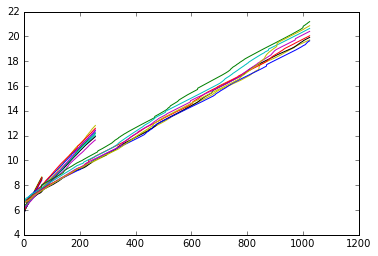

In [72]:
StageInArrivalTimes = np.concatenate([rp_haus_16_32_short['StageInPending'],rp_haus_64_16_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_short['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_16_32_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_64_16_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_med['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_16_32_long['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_64_16_long['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_256_8_long['StageInPending']])
StageInArrivalTimes = np.concatenate([StageInArrivalTimes,rp_haus_1024_4_long['StageInPending']])



## 1.2 Overall plotting values

# Spark Experiments

In [6]:
SparkExps = pandas.DataFrame.from_csv('Spark/comet2.csv')
data_list=list()
for name in SparkExps['JsonName']:
    data = SparkLogToDataFrame(name,'Spark/AppDataComet/Iter2/')
    data_list.append(data)

SparkExps['appData'] = data_list

SparkExps[0:]

,Atom,Length,Window,Tasks,Run,DataInit,TotalTime,JsonName,appData
Index,,,,,,,,,
0,CA,Short,32,21,1,7.00,23.00,app-20161010131806-0000,TaskId LaunchTime SchedulerDelay Dese...
1,CA,Short,32,21,2,5.00,21.00,app-20161010134803-0000,TaskId LaunchTime SchedulerDelay Dese...
2,CA,Short,32,21,3,3.00,19.00,app-20161010135547-0000,TaskId LaunchTime SchedulerDelay Dese...
3,CA,Short,24,36,1,2.00,18.00,app-20161010140155-0000,TaskId LaunchTime SchedulerDelay Dese...
4,CA,Short,24,36,2,6.00,21.00,app-20161010144938-0000,TaskId LaunchTime SchedulerDelay Dese...
5,CA,Short,24,36,3,5.00,20.00,app-20161010161029-0000,TaskId LaunchTime SchedulerDelay Dese...
6,CA,Short,16,78,1,4.00,11.00,app-20161010163843-0000,TaskId LaunchTime SchedulerDelay Dese...
7,CA,Short,16,78,2,5.00,13.00,app-20161010172155-0000,TaskId LaunchTime SchedulerDelay Dese...
8,CA,Short,16,78,3,2.00,10.00,app-20161010173249-0000,TaskId LaunchTime SchedulerDelay Dese...


In [12]:
SparkExps['JsonName'][7]

'app-20161010172155-0000'

In [42]:
SparkPrExps = pandas.DataFrame.from_csv('Spark/comet3.csv')
data_list=list()
for session,name in zip(SparkPrExps['SessionName'],SparkPrExps['JsonName']): 
    data = SparkSessionToDataFrame(session,'Spark/AppDataComet/Iter3/',name)
    tidyData = pandas.DataFrame(columns=['TaskTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','ResultSize','ReadTime','Exec'])
    tidyData.loc[0]=[(data['FinishTime'][1:]-data['LaunchTime']).mean()/1000,\
                 data['SchedulerDelay'][1:].mean()/1000,\
                 data['DeserializeTime'][1:].mean()/1000,\
                 data['Runtime'][1:].mean()/1000,\
                 data['ResultSerialization'][1:].mean()/1000,\
                 data['ResultSize'][1:].mean(),\
                 data['ReadTime'][1:].mean(),\
                 data['Exec'][1:].mean()]
    tidyData.to_csv(session+'.csv')
    data_list.append(data)
    
SparkPrExps['appData'] = data_list


Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_1/unit.000000/app-20161111194657-0000
Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_2/unit.000000/app-20161111195158-0000
Spark/AppDataComet/Iter3/spcopr_haus_21_32_ca_short_3/unit.000000/app-20161111195356-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_1/unit.000000/app-20161111195659-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_2/unit.000000/app-20161111200106-0000
Spark/AppDataComet/Iter3/spcopr_haus_36_24_ca_short_3/unit.000000/app-20161111200511-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_1/unit.000000/app-20161111200808-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_2/unit.000000/app-20161111201010-0000
Spark/AppDataComet/Iter3/spcopr_haus_78_16_ca_short_3/unit.000000/app-20161111201210-0000
Spark/AppDataComet/Iter3/spcopr_haus_136_12_ca_short_1/unit.000000/app-20161111205035-0000
Spark/AppDataComet/Iter3/spcopr_haus_136_12_ca_short_2/unit.000000/app-20161111205241-0000
Spark/Ap

In [20]:
tidyData = pandas.DataFrame(columns=['TaskTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','ResultSize','ReadTime','Exec'])
tidyData.loc[0]=[(data['FinishTime'][1:]-data['LaunchTime']).mean()/1000,
                 data['SchedulerDelay'][1:].mean()/1000,\
                 data['DeserializeTime'][1:].mean()/1000,\
                 data['Runtime'][1:].mean()/1000,\
                 data['ResultSerialization'][1:].mean()/1000,\
                 data['ResultSize'][1:].mean(),\
                 data['ReadTime'][1:].mean(),\
                 data['Exec'][1:].mean()]

tidyData

,TaskTime,SchedulerDelay,DeserializeTime,Runtime,ResultSerialization,ResultSize,ReadTime,Exec
0,4.345341,0.118786,0.375545,3.850964,0.000045,1460.227273,0.0,2.274621


In [14]:
print SparkExps['appData'][0]['ResultSize'].mean(),SparkExps['appData'][1]['ResultSize'].mean(),SparkExps['appData'][2]['ResultSize'].mean()
print SparkExps['appData'][3]['ResultSize'].mean(),SparkExps['appData'][4]['ResultSize'].mean(),SparkExps['appData'][5]['ResultSize'].mean()
print SparkExps['appData'][6]['ResultSize'].mean(),SparkExps['appData'][7]['ResultSize'].mean(),SparkExps['appData'][8]['ResultSize'].mean()
print SparkExps['appData'][9]['ResultSize'].mean(),SparkExps['appData'][10]['ResultSize'].mean(),SparkExps['appData'][11]['ResultSize'].mean()
print SparkExps['appData'][12]['ResultSize'].mean(),SparkExps['appData'][13]['ResultSize'].mean(),SparkExps['appData'][14]['ResultSize'].mean()
print SparkExps['appData'][15]['ResultSize'].mean(),SparkExps['appData'][16]['ResultSize'].mean(),SparkExps['appData'][17]['ResultSize'].mean()

print SparkExps['appData'][18]['ResultSize'].mean(),SparkExps['appData'][19]['ResultSize'].mean(),SparkExps['appData'][20]['ResultSize'].mean()

9374.0 9373.0 9374.0
9373.0 9373.52380952 9374.0
3200.0 3199.0 3200.0
2301.50735294 2301.47058824 2301.5
1656.44 1656.84666667 1656.30666667
1432.90909091 1432.04545455 1432.45454545
9374.0 9374.0 9374.0


In [15]:
np.mean([(SparkExps['TotalTime'][6] - (SparkExps['appData'][6]['FinishTime'] - SparkExps['appData'][6]['LaunchTime'])/1000),(SparkExps['TotalTime'][7] - (SparkExps['appData'][7]['FinishTime'] - SparkExps['appData'][7]['LaunchTime'])/1000),(SparkExps['TotalTime'][8] - (SparkExps['appData'][8]['FinishTime'] - SparkExps['appData'][8]['LaunchTime'])/1000)])

5.5894444444444451

In [43]:
# Short Trajectories
spco_stagein_short_ca = np.array([SparkPrExps[0:3]['DataInit'].mean(),
                                  SparkPrExps[3:6]['DataInit'].mean(),
                                  SparkPrExps[6:9]['DataInit'].mean(),
                                  SparkPrExps[9:12]['DataInit'].mean(),
                                  SparkPrExps[12:15]['DataInit'].mean(),
                                  SparkPrExps[15:18]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_short_ca=np.zeros((6,1))
spco_schedulerdelay_short_ca[0] = np.mean([SparkPrExps['appData'][0]['SchedulerDelay'],
                                           SparkPrExps['appData'][1]['SchedulerDelay'],
                                           SparkPrExps['appData'][2]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[1] = np.mean([SparkPrExps['appData'][3]['SchedulerDelay'],
                                           SparkPrExps['appData'][4]['SchedulerDelay'],
                                           SparkPrExps['appData'][5]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[2] = np.mean([SparkPrExps['appData'][6]['SchedulerDelay'],
                                           SparkPrExps['appData'][7]['SchedulerDelay'],
                                           SparkPrExps['appData'][8]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[3] = np.mean([SparkPrExps['appData'][9]['SchedulerDelay'],
                                           SparkPrExps['appData'][10]['SchedulerDelay'],
                                           SparkPrExps['appData'][11]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[4] = np.mean([SparkPrExps['appData'][12]['SchedulerDelay'],
                                           SparkPrExps['appData'][13]['SchedulerDelay']])/1000
spco_schedulerdelay_short_ca[5] = np.mean([SparkPrExps['appData'][15]['SchedulerDelay'],
                                           SparkPrExps['appData'][16]['SchedulerDelay'],
                                           SparkPrExps['appData'][17]['SchedulerDelay']])/1000

spco_execution_short_ca = np.zeros((6,1))
spco_execution_short_ca[0] = np.mean([(SparkPrExps['appData'][0]['Runtime']+SparkPrExps['appData'][0]['DeserializeTime']+SparkPrExps['appData'][0]['ResultSerialization']),
                                      (SparkPrExps['appData'][1]['Runtime']+SparkPrExps['appData'][1]['DeserializeTime']+SparkPrExps['appData'][1]['ResultSerialization']),
                                      (SparkPrExps['appData'][2]['Runtime']+SparkPrExps['appData'][2]['DeserializeTime']+SparkPrExps['appData'][2]['ResultSerialization'])])/1000
spco_execution_short_ca[1] = np.mean([(SparkPrExps['appData'][3]['Runtime']+SparkPrExps['appData'][3]['DeserializeTime']+SparkPrExps['appData'][3]['ResultSerialization']),
                                      (SparkPrExps['appData'][4]['Runtime']+SparkPrExps['appData'][4]['DeserializeTime']+SparkPrExps['appData'][4]['ResultSerialization']),
                                      (SparkPrExps['appData'][5]['Runtime']+SparkPrExps['appData'][5]['DeserializeTime']+SparkPrExps['appData'][5]['ResultSerialization'])])/1000
spco_execution_short_ca[2] = np.mean([(SparkPrExps['appData'][6]['Runtime']+SparkPrExps['appData'][6]['DeserializeTime']+SparkPrExps['appData'][6]['ResultSerialization']),
                                      (SparkPrExps['appData'][7]['Runtime']+SparkPrExps['appData'][7]['DeserializeTime']+SparkPrExps['appData'][7]['ResultSerialization']),
                                      (SparkPrExps['appData'][8]['Runtime']+SparkPrExps['appData'][8]['DeserializeTime']+SparkPrExps['appData'][8]['ResultSerialization'])])/1000
spco_execution_short_ca[3] = np.mean([(SparkPrExps['appData'][9]['Runtime']+SparkPrExps['appData'][9]['DeserializeTime']+SparkPrExps['appData'][9]['ResultSerialization']),
                                      (SparkPrExps['appData'][10]['Runtime']+SparkPrExps['appData'][10]['DeserializeTime']+SparkPrExps['appData'][10]['ResultSerialization']),
                                      (SparkPrExps['appData'][11]['Runtime']+SparkPrExps['appData'][11]['DeserializeTime']+SparkPrExps['appData'][11]['ResultSerialization'])])/1000
spco_execution_short_ca[4] = np.mean([(SparkPrExps['appData'][12]['Runtime']+SparkPrExps['appData'][12]['DeserializeTime']+SparkPrExps['appData'][12]['ResultSerialization']),
                                      (SparkPrExps['appData'][13]['Runtime']+SparkPrExps['appData'][13]['DeserializeTime']+SparkPrExps['appData'][13]['ResultSerialization'])])/1000
spco_execution_short_ca[5] = np.mean([(SparkPrExps['appData'][15]['Runtime']+SparkPrExps['appData'][15]['DeserializeTime']+SparkPrExps['appData'][15]['ResultSerialization']),
                                      (SparkPrExps['appData'][16]['Runtime']+SparkPrExps['appData'][16]['DeserializeTime']+SparkPrExps['appData'][16]['ResultSerialization']),
                                      (SparkPrExps['appData'][17]['Runtime']+SparkPrExps['appData'][17]['DeserializeTime']+SparkPrExps['appData'][17]['ResultSerialization'])])/1000

spco_stageout_short_ca = np.zeros((6,1))
spco_stageout_short_ca[0] = np.mean([(SparkPrExps['TotalTime'][0] - (SparkPrExps['appData'][0]['FinishTime'] - SparkPrExps['appData'][0]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][1] - (SparkPrExps['appData'][1]['FinishTime'] - SparkPrExps['appData'][1]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][2] - (SparkPrExps['appData'][2]['FinishTime'] - SparkPrExps['appData'][2]['LaunchTime'])/1000)])
spco_stageout_short_ca[1] = np.mean([(SparkPrExps['TotalTime'][3] - (SparkPrExps['appData'][3]['FinishTime'] - SparkPrExps['appData'][3]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][4] - (SparkPrExps['appData'][4]['FinishTime'] - SparkPrExps['appData'][4]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][5] - (SparkPrExps['appData'][5]['FinishTime'] - SparkPrExps['appData'][5]['LaunchTime'])/1000)])
spco_stageout_short_ca[2] = np.mean([(SparkPrExps['TotalTime'][6] - (SparkPrExps['appData'][6]['FinishTime'] - SparkPrExps['appData'][6]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][7] - (SparkPrExps['appData'][7]['FinishTime'] - SparkPrExps['appData'][7]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][8] - (SparkPrExps['appData'][8]['FinishTime'] - SparkPrExps['appData'][8]['LaunchTime'])/1000)])
spco_stageout_short_ca[3] = np.mean([(SparkPrExps['TotalTime'][9] - (SparkPrExps['appData'][9]['FinishTime'] - SparkPrExps['appData'][9]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][10] - (SparkPrExps['appData'][10]['FinishTime'] - SparkPrExps['appData'][10]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][11] - (SparkPrExps['appData'][11]['FinishTime'] - SparkPrExps['appData'][11]['LaunchTime'])/1000)])
spco_stageout_short_ca[4] = np.mean([(SparkPrExps['TotalTime'][12] - (SparkPrExps['appData'][12]['FinishTime'] - SparkPrExps['appData'][12]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][13] - (SparkPrExps['appData'][13]['FinishTime'] - SparkPrExps['appData'][13]['LaunchTime'])/1000)])
spco_stageout_short_ca[5] = np.mean([(SparkPrExps['TotalTime'][15] - (SparkPrExps['appData'][15]['FinishTime'] - SparkPrExps['appData'][15]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][16] - (SparkPrExps['appData'][16]['FinishTime'] - SparkPrExps['appData'][16]['LaunchTime'])/1000),
                                     (SparkPrExps['TotalTime'][17] - (SparkPrExps['appData'][17]['FinishTime'] - SparkPrExps['appData'][17]['LaunchTime'])/1000)])

In [44]:
# Medium Trajectory
spco_stagein_med_ca = np.array([SparkPrExps[18:21]['DataInit'].mean(),
                                SparkPrExps[21:24]['DataInit'].mean(),
                                SparkPrExps[24:27]['DataInit'].mean(),
                                SparkPrExps[27:30]['DataInit'].mean(),
                                SparkPrExps[30:33]['DataInit'].mean(),
                                SparkPrExps[33:36]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_med_ca=np.zeros((6,1))
spco_schedulerdelay_med_ca[0] = np.mean([SparkPrExps['appData'][18]['SchedulerDelay'],
                                         SparkPrExps['appData'][19]['SchedulerDelay'],
                                         SparkPrExps['appData'][20]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[1] = np.mean([SparkPrExps['appData'][21]['SchedulerDelay'],
                                         SparkPrExps['appData'][22]['SchedulerDelay'],
                                         SparkPrExps['appData'][23]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[2] = np.mean([SparkPrExps['appData'][24]['SchedulerDelay'],
                                         SparkPrExps['appData'][25]['SchedulerDelay'],
                                         SparkPrExps['appData'][26]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[3] = np.mean([SparkPrExps['appData'][27]['SchedulerDelay'],
                                         SparkPrExps['appData'][28]['SchedulerDelay'],
                                         SparkPrExps['appData'][29]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[4] = np.mean([SparkPrExps['appData'][30]['SchedulerDelay'],
                                         SparkPrExps['appData'][31]['SchedulerDelay'],
                                         SparkPrExps['appData'][32]['SchedulerDelay']])/1000
spco_schedulerdelay_med_ca[5] = np.mean([SparkPrExps['appData'][33]['SchedulerDelay'],
                                         SparkPrExps['appData'][34]['SchedulerDelay'],
                                         SparkPrExps['appData'][35]['SchedulerDelay']])/1000

spco_execution_med_ca = np.zeros((6,1))
spco_execution_med_ca[0] = np.mean([(SparkPrExps['appData'][18]['Runtime']+SparkPrExps['appData'][18]['DeserializeTime']+SparkPrExps['appData'][18]['ResultSerialization']),
                                    (SparkPrExps['appData'][19]['Runtime']+SparkPrExps['appData'][19]['DeserializeTime']+SparkPrExps['appData'][19]['ResultSerialization']),
                                    (SparkPrExps['appData'][20]['Runtime']+SparkPrExps['appData'][20]['DeserializeTime']+SparkPrExps['appData'][20]['ResultSerialization'])])/1000
spco_execution_med_ca[1] = np.mean([(SparkPrExps['appData'][21]['Runtime']+SparkPrExps['appData'][21]['DeserializeTime']+SparkPrExps['appData'][21]['ResultSerialization']),
                                    (SparkPrExps['appData'][22]['Runtime']+SparkPrExps['appData'][22]['DeserializeTime']+SparkPrExps['appData'][22]['ResultSerialization']),
                                    (SparkPrExps['appData'][23]['Runtime']+SparkPrExps['appData'][23]['DeserializeTime']+SparkPrExps['appData'][23]['ResultSerialization'])])/1000
spco_execution_med_ca[2] = np.mean([(SparkPrExps['appData'][24]['Runtime']+SparkPrExps['appData'][24]['DeserializeTime']+SparkPrExps['appData'][24]['ResultSerialization']),
                                    (SparkPrExps['appData'][25]['Runtime']+SparkPrExps['appData'][25]['DeserializeTime']+SparkPrExps['appData'][25]['ResultSerialization']),
                                    (SparkPrExps['appData'][26]['Runtime']+SparkPrExps['appData'][26]['DeserializeTime']+SparkPrExps['appData'][26]['ResultSerialization'])])/1000
spco_execution_med_ca[3] = np.mean([(SparkPrExps['appData'][27]['Runtime']+SparkPrExps['appData'][27]['DeserializeTime']+SparkPrExps['appData'][27]['ResultSerialization']),
                                    (SparkPrExps['appData'][28]['Runtime']+SparkPrExps['appData'][28]['DeserializeTime']+SparkPrExps['appData'][28]['ResultSerialization']),
                                    (SparkPrExps['appData'][29]['Runtime']+SparkPrExps['appData'][29]['DeserializeTime']+SparkPrExps['appData'][29]['ResultSerialization'])])/1000
spco_execution_med_ca[4] = np.mean([(SparkPrExps['appData'][30]['Runtime']+SparkPrExps['appData'][30]['DeserializeTime']+SparkPrExps['appData'][30]['ResultSerialization']),
                                    (SparkPrExps['appData'][31]['Runtime']+SparkPrExps['appData'][31]['DeserializeTime']+SparkPrExps['appData'][31]['ResultSerialization']),
                                    (SparkPrExps['appData'][32]['Runtime']+SparkPrExps['appData'][32]['DeserializeTime']+SparkPrExps['appData'][32]['ResultSerialization'])])/1000
spco_execution_med_ca[5] = np.mean([(SparkPrExps['appData'][33]['Runtime']+SparkPrExps['appData'][33]['DeserializeTime']+SparkPrExps['appData'][33]['ResultSerialization']),
                                    (SparkPrExps['appData'][34]['Runtime']+SparkPrExps['appData'][34]['DeserializeTime']+SparkPrExps['appData'][34]['ResultSerialization']),
                                    (SparkPrExps['appData'][35]['Runtime']+SparkPrExps['appData'][35]['DeserializeTime']+SparkPrExps['appData'][35]['ResultSerialization'])])/1000

spco_stageout_med_ca = np.zeros((6,1))
spco_stageout_med_ca[0] = np.mean([(SparkPrExps['TotalTime'][18] - (SparkPrExps['appData'][18]['FinishTime'] - SparkPrExps['appData'][18]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][19] - (SparkPrExps['appData'][19]['FinishTime'] - SparkPrExps['appData'][19]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][20] - (SparkPrExps['appData'][20]['FinishTime'] - SparkPrExps['appData'][20]['LaunchTime'])/1000)])
spco_stageout_med_ca[1] = np.mean([(SparkPrExps['TotalTime'][21] - (SparkPrExps['appData'][21]['FinishTime'] - SparkPrExps['appData'][21]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][22] - (SparkPrExps['appData'][22]['FinishTime'] - SparkPrExps['appData'][22]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][23] - (SparkPrExps['appData'][23]['FinishTime'] - SparkPrExps['appData'][23]['LaunchTime'])/1000)])
spco_stageout_med_ca[2] = np.mean([(SparkPrExps['TotalTime'][24] - (SparkPrExps['appData'][24]['FinishTime'] - SparkPrExps['appData'][24]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][25] - (SparkPrExps['appData'][25]['FinishTime'] - SparkPrExps['appData'][25]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][26] - (SparkPrExps['appData'][26]['FinishTime'] - SparkPrExps['appData'][26]['LaunchTime'])/1000)])
spco_stageout_med_ca[3] = np.mean([(SparkPrExps['TotalTime'][27] - (SparkPrExps['appData'][27]['FinishTime'] - SparkPrExps['appData'][27]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][28] - (SparkPrExps['appData'][28]['FinishTime'] - SparkPrExps['appData'][28]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][29] - (SparkPrExps['appData'][29]['FinishTime'] - SparkPrExps['appData'][29]['LaunchTime'])/1000)])
spco_stageout_med_ca[4] = np.mean([(SparkPrExps['TotalTime'][30] - (SparkPrExps['appData'][30]['FinishTime'] - SparkPrExps['appData'][30]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][31] - (SparkPrExps['appData'][31]['FinishTime'] - SparkPrExps['appData'][31]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][32] - (SparkPrExps['appData'][32]['FinishTime'] - SparkPrExps['appData'][32]['LaunchTime'])/1000)])
spco_stageout_med_ca[5] = np.mean([(SparkPrExps['TotalTime'][33] - (SparkPrExps['appData'][33]['FinishTime'] - SparkPrExps['appData'][33]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][34] - (SparkPrExps['appData'][34]['FinishTime'] - SparkPrExps['appData'][34]['LaunchTime'])/1000),
                                   (SparkPrExps['TotalTime'][35] - (SparkPrExps['appData'][35]['FinishTime'] - SparkPrExps['appData'][35]['LaunchTime'])/1000)])

In [45]:
# Long Trajectory
spco_stagein_long_ca = np.array([SparkPrExps[36:39]['DataInit'].mean(),
                                 SparkPrExps[39:42]['DataInit'].mean(),
                                 SparkPrExps[42:45]['DataInit'].mean(),
                                 SparkPrExps[45:48]['DataInit'].mean(),
                                 SparkPrExps[48:51]['DataInit'].mean(),
                                 SparkPrExps[51:54]['DataInit'].mean()]).reshape((6,1))

spco_schedulerdelay_long_ca=np.zeros((6,1))
spco_schedulerdelay_long_ca[0] = np.mean([SparkPrExps['appData'][36]['SchedulerDelay'],
                                          SparkPrExps['appData'][37]['SchedulerDelay'],
                                          SparkPrExps['appData'][38]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[1] = np.mean([SparkPrExps['appData'][39]['SchedulerDelay'],
                                          SparkPrExps['appData'][40]['SchedulerDelay'],
                                          SparkPrExps['appData'][41]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[2] = np.mean([SparkPrExps['appData'][42]['SchedulerDelay'],
                                          SparkPrExps['appData'][43]['SchedulerDelay'],
                                          SparkPrExps['appData'][44]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[3] = np.mean([SparkPrExps['appData'][45]['SchedulerDelay'],
                                          SparkPrExps['appData'][46]['SchedulerDelay'],
                                          SparkPrExps['appData'][47]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[4] = np.mean([SparkPrExps['appData'][48]['SchedulerDelay'],
                                          SparkPrExps['appData'][49]['SchedulerDelay'],
                                          SparkPrExps['appData'][50]['SchedulerDelay']])/1000
spco_schedulerdelay_long_ca[5] = np.mean([SparkPrExps['appData'][51]['SchedulerDelay'],
                                          SparkPrExps['appData'][52]['SchedulerDelay'],
                                          SparkPrExps['appData'][53]['SchedulerDelay']])/1000

spco_execution_long_ca = np.zeros((6,1))
spco_execution_long_ca[0] = np.mean([(SparkPrExps['appData'][36]['Runtime']+SparkPrExps['appData'][36]['DeserializeTime']+SparkPrExps['appData'][36]['ResultSerialization']),
                                     (SparkPrExps['appData'][37]['Runtime']+SparkPrExps['appData'][37]['DeserializeTime']+SparkPrExps['appData'][37]['ResultSerialization']),
                                     (SparkPrExps['appData'][38]['Runtime']+SparkPrExps['appData'][38]['DeserializeTime']+SparkPrExps['appData'][38]['ResultSerialization'])])/1000
spco_execution_long_ca[1] = np.mean([(SparkPrExps['appData'][39]['Runtime']+SparkPrExps['appData'][39]['DeserializeTime']+SparkPrExps['appData'][39]['ResultSerialization']),
                                     (SparkPrExps['appData'][40]['Runtime']+SparkPrExps['appData'][40]['DeserializeTime']+SparkPrExps['appData'][40]['ResultSerialization']),
                                     (SparkPrExps['appData'][41]['Runtime']+SparkPrExps['appData'][41]['DeserializeTime']+SparkPrExps['appData'][41]['ResultSerialization'])])/1000
spco_execution_long_ca[2] = np.mean([(SparkPrExps['appData'][42]['Runtime']+SparkPrExps['appData'][42]['DeserializeTime']+SparkPrExps['appData'][42]['ResultSerialization']),
                                     (SparkPrExps['appData'][43]['Runtime']+SparkPrExps['appData'][43]['DeserializeTime']+SparkPrExps['appData'][43]['ResultSerialization']),
                                     (SparkPrExps['appData'][44]['Runtime']+SparkPrExps['appData'][44]['DeserializeTime']+SparkPrExps['appData'][44]['ResultSerialization'])])/1000
spco_execution_long_ca[3] = np.mean([(SparkPrExps['appData'][45]['Runtime']+SparkPrExps['appData'][45]['DeserializeTime']+SparkPrExps['appData'][45]['ResultSerialization']),
                                     (SparkPrExps['appData'][46]['Runtime']+SparkPrExps['appData'][46]['DeserializeTime']+SparkPrExps['appData'][46]['ResultSerialization']),
                                     (SparkPrExps['appData'][47]['Runtime']+SparkPrExps['appData'][47]['DeserializeTime']+SparkPrExps['appData'][47]['ResultSerialization'])])/1000
spco_execution_long_ca[4] = np.mean([(SparkPrExps['appData'][48]['Runtime']+SparkPrExps['appData'][48]['DeserializeTime']+SparkPrExps['appData'][48]['ResultSerialization']),
                                     (SparkPrExps['appData'][49]['Runtime']+SparkPrExps['appData'][49]['DeserializeTime']+SparkPrExps['appData'][49]['ResultSerialization']),
                                     (SparkPrExps['appData'][50]['Runtime']+SparkPrExps['appData'][50]['DeserializeTime']+SparkPrExps['appData'][50]['ResultSerialization'])])/1000
spco_execution_long_ca[5] = np.mean([(SparkPrExps['appData'][51]['Runtime']+SparkPrExps['appData'][51]['DeserializeTime']+SparkPrExps['appData'][51]['ResultSerialization']),
                                     (SparkPrExps['appData'][52]['Runtime']+SparkPrExps['appData'][52]['DeserializeTime']+SparkPrExps['appData'][52]['ResultSerialization']),
                                     (SparkPrExps['appData'][53]['Runtime']+SparkPrExps['appData'][53]['DeserializeTime']+SparkPrExps['appData'][53]['ResultSerialization'])])/1000

spco_stageout_long_ca = np.zeros((6,1))
spco_stageout_long_ca[0] = np.mean([(SparkPrExps['TotalTime'][36] - (SparkPrExps['appData'][36]['FinishTime'] - SparkPrExps['appData'][36]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][37] - (SparkPrExps['appData'][37]['FinishTime'] - SparkPrExps['appData'][37]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][38] - (SparkPrExps['appData'][38]['FinishTime'] - SparkPrExps['appData'][38]['LaunchTime'])/1000)])
spco_stageout_long_ca[1] = np.mean([(SparkPrExps['TotalTime'][39] - (SparkPrExps['appData'][39]['FinishTime'] - SparkPrExps['appData'][39]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][40] - (SparkPrExps['appData'][40]['FinishTime'] - SparkPrExps['appData'][40]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][41] - (SparkPrExps['appData'][41]['FinishTime'] - SparkPrExps['appData'][41]['LaunchTime'])/1000)])
spco_stageout_long_ca[2] = np.mean([(SparkPrExps['TotalTime'][42] - (SparkPrExps['appData'][42]['FinishTime'] - SparkPrExps['appData'][42]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][43] - (SparkPrExps['appData'][43]['FinishTime'] - SparkPrExps['appData'][43]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][44] - (SparkPrExps['appData'][44]['FinishTime'] - SparkPrExps['appData'][44]['LaunchTime'])/1000)])
spco_stageout_long_ca[3] = np.mean([(SparkPrExps['TotalTime'][45] - (SparkPrExps['appData'][45]['FinishTime'] - SparkPrExps['appData'][45]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][46] - (SparkPrExps['appData'][46]['FinishTime'] - SparkPrExps['appData'][46]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][47] - (SparkPrExps['appData'][47]['FinishTime'] - SparkPrExps['appData'][47]['LaunchTime'])/1000)])
spco_stageout_long_ca[4] = np.mean([(SparkPrExps['TotalTime'][48] - (SparkPrExps['appData'][48]['FinishTime'] - SparkPrExps['appData'][48]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][49] - (SparkPrExps['appData'][49]['FinishTime'] - SparkPrExps['appData'][49]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][50] - (SparkPrExps['appData'][50]['FinishTime'] - SparkPrExps['appData'][50]['LaunchTime'])/1000)])
spco_stageout_long_ca[5] = np.mean([(SparkPrExps['TotalTime'][51] - (SparkPrExps['appData'][51]['FinishTime'] - SparkPrExps['appData'][51]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][52] - (SparkPrExps['appData'][52]['FinishTime'] - SparkPrExps['appData'][52]['LaunchTime'])/1000),
                                    (SparkPrExps['TotalTime'][53] - (SparkPrExps['appData'][53]['FinishTime'] - SparkPrExps['appData'][53]['LaunchTime'])/1000)])

# Plotting

In [26]:
print rp_haus_16_32_short_ca_1['StageIn'].max()
print rp_haus_16_32_short['Execution'].mean()
print rp_haus_64_16_short_ca_1['StageIn'].max()
print rp_haus_64_16_short['Execution'].mean()
print rp_haus_256_8_short_ca_1['StageIn'].max()
print rp_haus_256_8_short['Execution'].mean()
print rp_haus_1024_4_short_ca_1['StageIn'].max()
print rp_haus_1024_4_short['Execution'].mean()

7.1274831295
25.467867742
8.49556398392
7.00346226494
12.0331840515
2.0758777031
24.969165802
0.764854540427


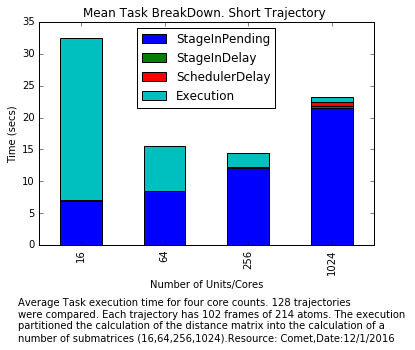

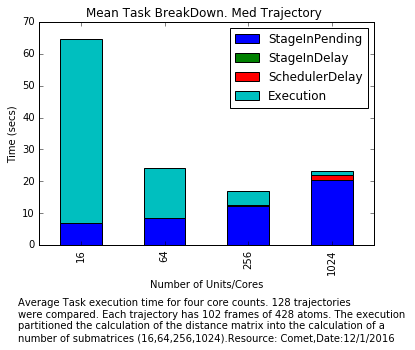

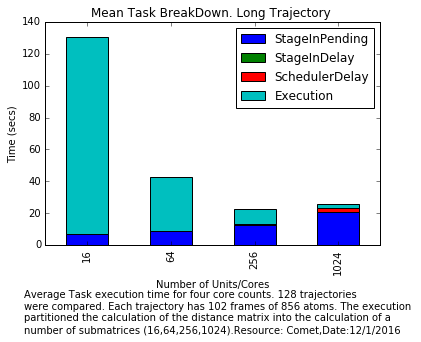

In [43]:
rp_haus_short_plot=pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution'])
data=[np.mean([rp_haus_16_32_short['StageInPending'][0:16].max(),rp_haus_16_32_short['StageInPending'][16:32].max(),rp_haus_16_32_short['StageInPending'][32:48].max()]),\
      rp_haus_16_32_short['StageInDelay'].mean(),\
      rp_haus_16_32_short['SchedulerDelay'].mean(),\
      rp_haus_16_32_short['Execution'].mean()]
rp_haus_short_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_short['StageInPending'][0:64].max(),rp_haus_64_16_short['StageInPending'][64:128].max(),rp_haus_64_16_short['StageInPending'][128:192].max()]),\
      rp_haus_64_16_short['StageInDelay'].mean(),\
      rp_haus_64_16_short['SchedulerDelay'].mean(),\
      rp_haus_64_16_short['Execution'].mean()]
rp_haus_short_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_short['StageInPending'][0:256].max(),rp_haus_256_8_short['StageInPending'][256:512].max(),rp_haus_256_8_short['StageInPending'][512:768].max()]),\
      rp_haus_256_8_short['StageInDelay'].mean(),\
      rp_haus_256_8_short['SchedulerDelay'].mean(),\
      rp_haus_256_8_short['Execution'].mean()]
rp_haus_short_plot.loc[256]=data
data=[np.mean([rp_haus_1024_4_short['StageInPending'][0:1024].max(),rp_haus_1024_4_short['StageInPending'][1024:2048].max(),rp_haus_1024_4_short['StageInPending'][2048:3072].max()]),\
      rp_haus_1024_4_short['StageInDelay'].mean(),\
      rp_haus_1024_4_short['SchedulerDelay'].mean(),\
      rp_haus_1024_4_short['Execution'].mean()]
rp_haus_short_plot.loc[1024]=data
rp_haus_short_plot.plot(kind='bar',stacked=True)
plt.title('Mean Task BreakDown. Short Trajectory ')
plt.xlabel('Number of Units/Cores')
plt.ylabel('Time (secs)')
plt.text(-0.75,-15,'Average Task execution time for four core counts. 128 trajectories\n\
were compared. Each trajectory has 102 frames of 214 atoms. The execution \n\
partitioned the calculation of the distance matrix into the calculation of a\n\
number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('MeanTaskBreakDownPower2Short.pdf',bbox_inches='tight')
#rp_haus_short_plot.plot(kind='bar',stacked=True,log=1)
#plt.title('Mean Task BreakDown. Short Trajectory ')
#plt.xlabel('Number of Units/Cores')
#plt.ylabel('Time (secs)')
#plt.text(-0.75,.1,'Average Task execution time for four core counts. 128 trajectories\n\
#were compared. Each trajectory has 102 frames of 214 atoms. The execution \n\
#partitioned the calculation of the distance matrix into the calculation of a\n\
#number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('LogMeanTaskBreakDownPower2Short.pdf',bbox_inches='tight')

rp_haus_med_plot=pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution'])
data=[np.mean([rp_haus_16_32_med['StageInPending'][0:16].max(),rp_haus_16_32_med['StageInPending'][16:32].max(),rp_haus_16_32_med['StageInPending'][32:48].max()]),\
      rp_haus_16_32_med['StageInDelay'].mean(),\
      rp_haus_16_32_med['SchedulerDelay'].mean(),\
      rp_haus_16_32_med['Execution'].mean()]
rp_haus_med_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_med['StageInPending'][0:64].max(),rp_haus_64_16_med['StageInPending'][64:128].max(),rp_haus_64_16_med['StageInPending'][128:192].max()]),\
      rp_haus_64_16_med['StageInDelay'].mean(),\
      rp_haus_64_16_med['SchedulerDelay'].mean(),\
      rp_haus_64_16_med['Execution'].mean()]
rp_haus_med_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_med['StageInPending'][0:256].max(),rp_haus_256_8_med['StageInPending'][256:512].max(),rp_haus_256_8_med['StageInPending'][512:768].max()]),\
      rp_haus_256_8_med['StageInDelay'].mean(),\
      rp_haus_256_8_med['SchedulerDelay'].mean(),\
      rp_haus_256_8_med['Execution'].mean()]
rp_haus_med_plot.loc[256]=data
data=[np.mean([rp_haus_1024_4_med['StageInPending'][0:1024].max(),rp_haus_1024_4_med['StageInPending'][1024:2048].max(),rp_haus_1024_4_med['StageInPending'][2048:3072].max()]),\
      rp_haus_1024_4_med['StageInDelay'].mean(),\
      rp_haus_1024_4_med['SchedulerDelay'].mean(),\
      rp_haus_1024_4_med['Execution'].mean()]
rp_haus_med_plot.loc[1024]=data
rp_haus_med_plot.plot(kind='bar',stacked=True)
plt.title('Mean Task BreakDown. Med Trajectory ')
plt.xlabel('Number of Units/Cores')
plt.ylabel('Time (secs)')
plt.text(-0.75,-30,'Average Task execution time for four core counts. 128 trajectories\n\
were compared. Each trajectory has 102 frames of 428 atoms. The execution \n\
partitioned the calculation of the distance matrix into the calculation of a\n\
number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('MeanTaskBreakDownPower2Med.pdf',bbox_inches='tight')
#rp_haus_med_plot.plot(kind='bar',stacked=True,log=1)
#plt.title('Mean Task BreakDown. Med Trajectory ')
#plt.xlabel('Number of Units/Cores')
#plt.ylabel('Time (secs)')
#plt.text(-0.75,.1,'Average Task execution time for four core counts. 128 trajectories\n\
#were compared. Each trajectory has 102 frames of 428 atoms. The execution \n\
#partitioned the calculation of the distance matrix into the calculation of a\n\
#number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('LogMeanTaskBreakDownPower2Med.pdf',bbox_inches='tight')

rp_haus_long_plot=pandas.DataFrame(columns=['StageInPending','StageInDelay','SchedulerDelay','Execution'])
data=[np.mean([rp_haus_16_32_long['StageInPending'][0:16].max(),rp_haus_16_32_long['StageInPending'][16:32].max(),rp_haus_16_32_long['StageInPending'][32:48].max()]),\
      rp_haus_16_32_long['StageInDelay'].mean(),\
      rp_haus_16_32_long['SchedulerDelay'].mean(),\
      rp_haus_16_32_long['Execution'].mean()]
rp_haus_long_plot.loc[16]=data
data=[np.mean([rp_haus_64_16_long['StageInPending'][0:64].max(),rp_haus_64_16_long['StageInPending'][64:128].max(),rp_haus_64_16_long['StageInPending'][128:192].max()]),\
      rp_haus_64_16_long['StageInDelay'].mean(),\
      rp_haus_64_16_long['SchedulerDelay'].mean(),\
      rp_haus_64_16_long['Execution'].mean()]
rp_haus_long_plot.loc[64]=data
data=[np.mean([rp_haus_256_8_long['StageInPending'][0:256].max(),rp_haus_256_8_long['StageInPending'][256:512].max(),rp_haus_256_8_long['StageInPending'][512:768].max()]),\
      rp_haus_256_8_long['StageInDelay'].mean(),\
      rp_haus_256_8_long['SchedulerDelay'].mean(),\
      rp_haus_256_8_long['Execution'].mean()]
rp_haus_long_plot.loc[256]=data
data=[np.mean([rp_haus_1024_4_long['StageInPending'][0:1024].max(),rp_haus_1024_4_long['StageInPending'][1024:2048].max(),rp_haus_1024_4_long['StageInPending'][2048:3072].max()]),\
      rp_haus_1024_4_long['StageInDelay'].mean(),\
      rp_haus_1024_4_long['SchedulerDelay'].mean(),\
      rp_haus_1024_4_long['Execution'].mean()]
rp_haus_long_plot.loc[1024]=data
rp_haus_long_plot.plot(kind='bar',stacked=True)
plt.title('Mean Task BreakDown. Long Trajectory ')
plt.xlabel('Number of Units/Cores')
plt.ylabel('Time (secs)')
plt.text(-0.75,-55,'Average Task execution time for four core counts. 128 trajectories\n\
were compared. Each trajectory has 102 frames of 856 atoms. The execution \n\
partitioned the calculation of the distance matrix into the calculation of a\n\
number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('MeanTaskBreakDownPower2Long.pdf',bbox_inches='tight')
#rp_haus_long_plot.plot(kind='bar',stacked=True,log=1)
#plt.title('Mean Task BreakDown. Long Trajectory ')
#plt.xlabel('Number of Units/Cores')
#plt.ylabel('Time (secs)')
#plt.text(-0.75,.05,'Average Task execution time for four core counts. 128 trajectories\n\
#were compared. Each trajectory has 102 frames of 856 atoms. The execution \n\
#partitioned the calculation of the distance matrix into the calculation of a\n\
#number of submatrices (16,64,256,1024).Resource: Comet,Date:12/1/2016')
#plt.savefig('LogMeanTaskBreakDownPower2Long.pdf',bbox_inches='tight')

In [112]:
rp_haus_short_plot=pandas.DataFrame(columns=['StageInPending','StageInPendingStd','StageInDelay','StageInDelayStd','SchedulerDelay','SchedulerDelayStd','Execution','ExecutionStd'])
data=[rp_haus_16_32_short['StageInPending'].mean(),\
      rp_haus_16_32_short['StageInPending'].std(),\
      rp_haus_16_32_short['StageInDelay'].mean(),\
      rp_haus_16_32_short['StageInDelay'].std(),\
      rp_haus_16_32_short['SchedulerDelay'].mean(),\
      rp_haus_16_32_short['SchedulerDelay'].std(),\
      rp_haus_16_32_short['Execution'].mean(),\
      rp_haus_16_32_short['Execution'].std()]
rp_haus_short_plot.loc[16]=data
data=[rp_haus_64_16_short['StageInPending'].mean(),\
      rp_haus_64_16_short['StageInPending'].std(),\
      rp_haus_64_16_short['StageInDelay'].mean(),\
      rp_haus_64_16_short['StageInDelay'].std(),\
      rp_haus_64_16_short['SchedulerDelay'].mean(),\
      rp_haus_64_16_short['SchedulerDelay'].std(),\
      rp_haus_64_16_short['Execution'].mean(),\
      rp_haus_64_16_short['Execution'].std()]
rp_haus_short_plot.loc[64]=data
data=[rp_haus_256_8_short['StageInPending'].mean(),\
      rp_haus_256_8_short['StageInPending'].std(),\
      rp_haus_256_8_short['StageInDelay'].mean(),\
      rp_haus_256_8_short['StageInDelay'].std(),\
      rp_haus_256_8_short['SchedulerDelay'].mean(),\
      rp_haus_256_8_short['SchedulerDelay'].std(),\
      rp_haus_256_8_short['Execution'].mean(),\
      rp_haus_256_8_short['Execution'].std()]
rp_haus_short_plot.loc[256]=data
data=[rp_haus_1024_4_short['StageInPending'].mean(),\
      rp_haus_1024_4_short['StageInPending'].std(),\
      rp_haus_1024_4_short['StageInDelay'].mean(),\
      rp_haus_1024_4_short['StageInDelay'].std(),\
      rp_haus_1024_4_short['SchedulerDelay'].mean(),\
      rp_haus_1024_4_short['SchedulerDelay'].std(),\
      rp_haus_1024_4_short['Execution'].mean(),\
      rp_haus_1024_4_short['Execution'].std()]
rp_haus_short_plot.loc[1024]=data

rp_haus_med_plot=pandas.DataFrame(columns=['StageInPending','StageInPendingStd','StageInDelay','StageInDelayStd','SchedulerDelay','SchedulerDelayStd','Execution','ExecutionStd'])
data=[rp_haus_16_32_med['StageInPending'].mean(),\
      rp_haus_16_32_med['StageInPending'].std(),\
      rp_haus_16_32_med['StageInDelay'].mean(),\
      rp_haus_16_32_med['StageInDelay'].std(),\
      rp_haus_16_32_med['SchedulerDelay'].mean(),\
      rp_haus_16_32_med['SchedulerDelay'].std(),\
      rp_haus_16_32_med['Execution'].mean(),\
      rp_haus_16_32_med['Execution'].std()]
rp_haus_med_plot.loc[16]=data
data=[rp_haus_64_16_med['StageInPending'].mean(),\
      rp_haus_64_16_med['StageInPending'].std(),\
      rp_haus_64_16_med['StageInDelay'].mean(),\
      rp_haus_64_16_med['StageInDelay'].std(),\
      rp_haus_64_16_med['SchedulerDelay'].mean(),\
      rp_haus_64_16_med['SchedulerDelay'].std(),\
      rp_haus_64_16_med['Execution'].mean(),\
      rp_haus_64_16_med['Execution'].std()]
rp_haus_med_plot.loc[64]=data
data=[rp_haus_256_8_med['StageInPending'].mean(),\
      rp_haus_256_8_med['StageInPending'].std(),\
      rp_haus_256_8_med['StageInDelay'].mean(),\
      rp_haus_256_8_med['StageInDelay'].std(),\
      rp_haus_256_8_med['SchedulerDelay'].mean(),\
      rp_haus_256_8_med['SchedulerDelay'].std(),\
      rp_haus_256_8_med['Execution'].mean(),\
      rp_haus_256_8_med['Execution'].std()]
rp_haus_med_plot.loc[256]=data
data=[rp_haus_1024_4_med['StageInPending'].mean(),\
      rp_haus_1024_4_med['StageInPending'].std(),\
      rp_haus_1024_4_med['StageInDelay'].mean(),\
      rp_haus_1024_4_med['StageInDelay'].std(),\
      rp_haus_1024_4_med['SchedulerDelay'].mean(),\
      rp_haus_1024_4_med['SchedulerDelay'].std(),\
      rp_haus_1024_4_med['Execution'].mean(),\
      rp_haus_1024_4_med['Execution'].std()]
rp_haus_med_plot.loc[1024]=data

rp_haus_long_plot=pandas.DataFrame(columns=['StageInPending','StageInPendingStd','StageInDelay','StageInDelayStd','SchedulerDelay','SchedulerDelayStd','Execution','ExecutionStd'])
data=[rp_haus_16_32_long['StageInPending'].mean(),\
      rp_haus_16_32_long['StageInPending'].std(),\
      rp_haus_16_32_long['StageInDelay'].mean(),\
      rp_haus_16_32_long['StageInDelay'].std(),\
      rp_haus_16_32_long['SchedulerDelay'].mean(),\
      rp_haus_16_32_long['SchedulerDelay'].std(),\
      rp_haus_16_32_long['Execution'].mean(),\
      rp_haus_16_32_long['Execution'].std()]
rp_haus_long_plot.loc[16]=data
data=[rp_haus_64_16_long['StageInPending'].mean(),\
      rp_haus_64_16_long['StageInPending'].std(),\
      rp_haus_64_16_long['StageInDelay'].mean(),\
      rp_haus_64_16_long['StageInDelay'].std(),\
      rp_haus_64_16_long['SchedulerDelay'].mean(),\
      rp_haus_64_16_long['SchedulerDelay'].std(),\
      rp_haus_64_16_long['Execution'].mean(),\
      rp_haus_64_16_long['Execution'].std()]
rp_haus_long_plot.loc[64]=data
data=[rp_haus_256_8_long['StageInPending'].mean(),\
      rp_haus_256_8_long['StageInPending'].std(),\
      rp_haus_256_8_long['StageInDelay'].mean(),\
      rp_haus_256_8_long['StageInDelay'].std(),\
      rp_haus_256_8_long['SchedulerDelay'].mean(),\
      rp_haus_256_8_long['SchedulerDelay'].std(),\
      rp_haus_256_8_long['Execution'].mean(),\
      rp_haus_256_8_long['Execution'].std()]
rp_haus_long_plot.loc[256]=data
data=[rp_haus_1024_4_long['StageInPending'].mean(),\
      rp_haus_1024_4_long['StageInPending'].std(),\
      rp_haus_1024_4_long['StageInDelay'].mean(),\
      rp_haus_1024_4_long['StageInDelay'].std(),\
      rp_haus_1024_4_long['SchedulerDelay'].mean(),\
      rp_haus_1024_4_long['SchedulerDelay'].std(),\
      rp_haus_1024_4_long['Execution'].mean(),\
      rp_haus_1024_4_long['Execution'].std()]
rp_haus_long_plot.loc[1024]=data

rp_haus_short_plot.to_csv('ydatashort.csv')
rp_haus_med_plot.to_csv('ydatamed.csv')
rp_haus_long_plot.to_csv('ydatalong.csv')

xdatashort = np.array([32*102,16*102,8*102,4*102])
xdatamed   = np.array([32*102,16*102,8*102,4*102])
xdatalong  = np.array([32*102,16*102,8*102,4*102])

ydatashort = rp_haus_short_plot['Execution'].as_matrix()
ydatamed = rp_haus_med_plot['Execution'].as_matrix()
ydatalong = rp_haus_long_plot['Execution'].as_matrix()
np.save('ydatashort.npy',ydatashort)
np.save('ydatamed.npy',ydatamed)
np.save('ydatalong.npy',ydatalong)

a_short = np.divide(np.divide(ydatashort,np.power(xdatashort,2)),214)
a_med = np.divide(np.divide(ydatamed,np.power(xdatamed,2)),428)
a_long = np.divide(np.divide(ydatalong,np.power(xdatalong,2)),856)

print np.mean([a_short,a_med,a_long])
print np.std([a_short,a_med,a_long])


1.51731835346e-08
2.80328727967e-09


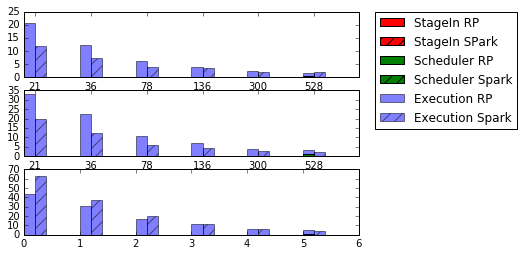

In [47]:
bar_l = np.arange(6)
width=0.20
a=plt.figure()
plt.title('Mean Task BreakDown')
plt.subplot(3, 1, 1)
#Stage IN
plt.bar(bar_l,[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_short_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn SPark',color='r')

# Scheduling
plt.bar(bar_l,[rp_haus_21_32_short['SchedulerDelay'].mean(),\
               rp_haus_36_24_short['SchedulerDelay'].mean(),\
               rp_haus_78_16_short['SchedulerDelay'].mean(),\
               rp_haus_136_12_short['SchedulerDelay'].mean(),\
               rp_haus_300_8_short['SchedulerDelay'].mean(),\
               rp_haus_528_6_short['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_short_ca,
        width,alpha=1.0,bottom=spco_stagein_short_ca,
        hatch='//',label='Scheduler Spark',color='g')

# Executing
plt.bar(bar_l,[rp_haus_21_32_short['Execution'].mean(),\
               rp_haus_36_24_short['Execution'].mean(),\
               rp_haus_78_16_short['Execution'].mean(),\
               rp_haus_136_12_short['Execution'].mean(),\
               rp_haus_300_8_short['Execution'].mean(),\
               rp_haus_528_6_short['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_short['SchedulerDelay'].mean()+rp_haus_21_32_short['StageInDelay'].mean(),\
                rp_haus_36_24_short['SchedulerDelay'].mean()+rp_haus_36_24_short['StageInDelay'].mean(),\
                rp_haus_78_16_short['SchedulerDelay'].mean()+rp_haus_78_16_short['StageInDelay'].mean(),\
                rp_haus_136_12_short['SchedulerDelay'].mean()+rp_haus_136_12_short['StageInDelay'].mean(),\
                rp_haus_300_8_short['SchedulerDelay'].mean()+rp_haus_300_8_short['StageInDelay'].mean(),\
                rp_haus_528_6_short['SchedulerDelay'].mean()+rp_haus_528_6_short['StageInDelay'].mean()],
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_short_ca,
        width,alpha=0.5,
        bottom=spco_stagein_short_ca+spco_schedulerdelay_short_ca,
        hatch='//',
        label='Execution Spark')

# Stage out and Finalization
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))


plt.subplot(3, 1, 2)
# Stage In

plt.bar(bar_l,[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_med_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

# Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_med['SchedulerDelay'].mean(),\
               rp_haus_36_24_med['SchedulerDelay'].mean(),\
               rp_haus_78_16_med['SchedulerDelay'].mean(),\
               rp_haus_136_12_med['SchedulerDelay'].mean(),\
               rp_haus_300_8_med['SchedulerDelay'].mean(),\
               rp_haus_528_6_med['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_med_ca,
        width,alpha=1.0,bottom=spco_stagein_med_ca,
        hatch='//',label='Scheduler',color='g')

# Execution 
plt.bar(bar_l,[rp_haus_21_32_med['Execution'].mean(),\
               rp_haus_36_24_med['Execution'].mean(),\
               rp_haus_78_16_med['Execution'].mean(),\
               rp_haus_136_12_med['Execution'].mean(),\
               rp_haus_300_8_med['Execution'].mean(),\
               rp_haus_528_6_med['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_med['SchedulerDelay'].mean()+rp_haus_21_32_med['StageInDelay'].mean(),\
                rp_haus_36_24_med['SchedulerDelay'].mean()+rp_haus_36_24_med['StageInDelay'].mean(),\
                rp_haus_78_16_med['SchedulerDelay'].mean()+rp_haus_78_16_med['StageInDelay'].mean(),\
                rp_haus_136_12_med['SchedulerDelay'].mean()+rp_haus_136_12_med['StageInDelay'].mean(),\
                rp_haus_300_8_med['SchedulerDelay'].mean()+rp_haus_300_8_med['StageInDelay'].mean(),\
                rp_haus_528_6_med['SchedulerDelay'].mean()+rp_haus_528_6_med['StageInDelay'].mean()],
        label='Execution')

plt.bar(bar_l+width,spco_execution_med_ca,
        width,alpha=0.5,
        bottom=spco_stagein_med_ca+spco_schedulerdelay_med_ca,
        hatch='//',
        label='Execution Spark')

# Stage Out
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.subplot(3, 1, 3)

# Stage In
plt.bar(bar_l,[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn',color='r')

plt.bar(bar_l+width,spco_stagein_long_ca,
        width,alpha=1.0,
        hatch='//',
        label='StageIn',color='r')

#Scheduling Delay
plt.bar(bar_l,[rp_haus_21_32_long['SchedulerDelay'].mean(),\
               rp_haus_36_24_long['SchedulerDelay'].mean(),\
               rp_haus_78_16_long['SchedulerDelay'].mean(),\
               rp_haus_136_12_long['SchedulerDelay'].mean(),\
               rp_haus_300_8_long['SchedulerDelay'].mean(),\
               rp_haus_528_6_long['SchedulerDelay'].mean()],
        width,alpha=1.0,bottom=[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        label='Scheduler',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_long_ca,
        width,alpha=1.0,bottom=spco_stagein_long_ca,
        hatch='//',label='Scheduler',color='g')

# Execution
plt.bar(bar_l,[rp_haus_21_32_long['Execution'].mean(),\
               rp_haus_36_24_long['Execution'].mean(),\
               rp_haus_78_16_long['Execution'].mean(),\
               rp_haus_136_12_long['Execution'].mean(),\
               rp_haus_300_8_long['Execution'].mean(),\
               rp_haus_528_6_long['Execution'].mean()],
        width,alpha=0.5,
        bottom=[rp_haus_21_32_long['SchedulerDelay'].mean()+rp_haus_21_32_long['StageInDelay'].mean(),\
                rp_haus_36_24_long['SchedulerDelay'].mean()+rp_haus_36_24_long['StageInDelay'].mean(),\
                rp_haus_78_16_long['SchedulerDelay'].mean()+rp_haus_78_16_long['StageInDelay'].mean(),\
                rp_haus_136_12_long['SchedulerDelay'].mean()+rp_haus_136_12_long['StageInDelay'].mean(),\
                rp_haus_300_8_long['SchedulerDelay'].mean()+rp_haus_300_8_long['StageInDelay'].mean(),\
                rp_haus_528_6_long['SchedulerDelay'].mean()+rp_haus_528_6_long['StageInDelay'].mean()],
        label='Execution')

plt.bar(bar_l+width,spco_execution_long_ca,
        width,alpha=0.5,
        bottom=spco_stagein_long_ca+spco_schedulerdelay_long_ca,
        hatch='//',
        label='Execution')

# Stage Out
plt.savefig('MeanTaskBreakDownPr.pdf',bbox_extra_artists=(lgd,),bbox_inches='tight')

In [27]:
haus_med_read = np.array([haus_21_32_med_exec_detail['Read'].mean(),\
                          haus_36_24_med_exec_detail['Read'].mean(),\
                          haus_78_16_med_exec_detail['Read'].mean(),\
                         haus_136_12_med_exec_detail['Read'].mean(),\
                          haus_300_8_med_exec_detail['Read'].mean(),\
                          haus_528_6_med_exec_detail['Read'].mean()])

haus_med_exec = np.array([haus_21_32_med_exec_detail['Exec'].mean(),\
                          haus_36_24_med_exec_detail['Exec'].mean(),\
                          haus_78_16_med_exec_detail['Exec'].mean(),\
                         haus_136_12_med_exec_detail['Exec'].mean(),\
                          haus_300_8_med_exec_detail['Exec'].mean(),\
                          haus_528_6_med_exec_detail['Exec'].mean()])

haus_med_write = np.array([haus_21_32_med_exec_detail['Write'].mean(),\
                           haus_36_24_med_exec_detail['Write'].mean(),\
                           haus_78_16_med_exec_detail['Write'].mean(),\
                           haus_136_12_med_exec_detail['Write'].mean(),\
                           haus_300_8_med_exec_detail['Write'].mean(),\
                           haus_528_6_med_exec_detail['Write'].mean()])

print haus_med_read
print haus_med_exec
print haus_med_write
print haus_21_32_med_exec_detail

[ 0.90663967  0.97442828  0.4732941   0.24708537  0.17977268  0.07048679]
[ 42.09187662  25.70340247  11.45205818   7.08370761   3.24401828
   1.85761192]
[ 0.01168024  0.00794572  0.00187899  0.00179123  0.00188875  0.05985468]
        Read       Exec     Write
0   1.161243  47.568997  0.015729
1   1.047776  48.703286  0.021018
2   1.315634  19.553040  0.002992
3   1.323230  47.664695  0.047324
4   0.898327  49.244150  0.013827
5   0.599272  45.745034  0.024901
6   0.960855  47.427330  0.002385
7   1.006272  37.957969  0.003809
8   0.674757  48.121838  0.004966
9   1.086013  48.602706  0.019085
10  0.337305  23.107362  0.011167
11  0.947801  19.130270  0.004002
12  0.814154  48.301719  0.014514
13  0.503514  49.125861  0.018708
14  1.135889  44.942722  0.005400
15  0.899491  49.281482  0.002089
16  0.718640  47.800309  0.004729
17  1.272572  44.394270  0.002635
18  0.260076  49.170970  0.002874
19  1.207253  44.952808  0.007362
20  0.869359  23.132591  0.015769


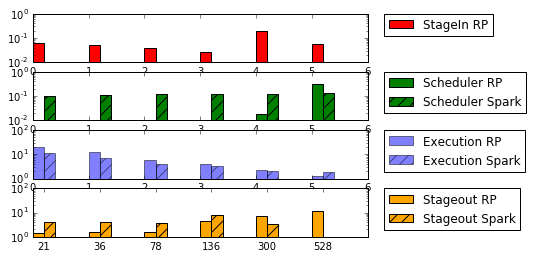

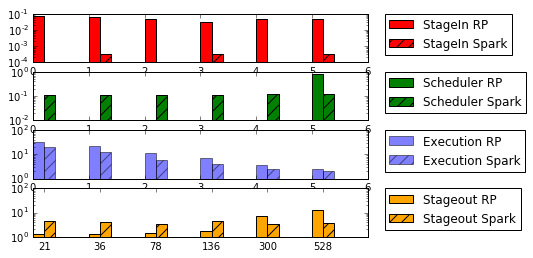

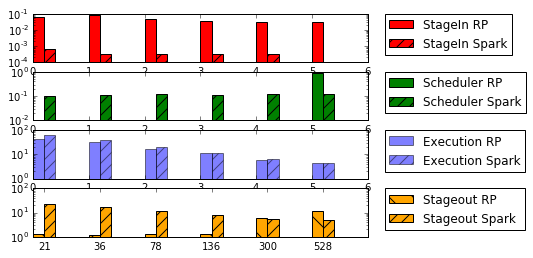

In [52]:
bar_l = np.arange(6)
width=0.20
a=plt.figure()
plt.title('Mean Task BreakDown')
plt.subplot(4, 1, 1)
#Stage IN
plt.bar(bar_l,[rp_haus_21_32_short['StageInDelay'].mean(),\
               rp_haus_36_24_short['StageInDelay'].mean(),\
               rp_haus_78_16_short['StageInDelay'].mean(),\
               rp_haus_136_12_short['StageInDelay'].mean(),\
               rp_haus_300_8_short['StageInDelay'].mean(),\
               rp_haus_528_6_short['StageInDelay'].mean()],
        width,alpha=1.0,log=1,
        label='StageIn RP',color='r')

#plt.bar(bar_l+width,spco_stagein_short_ca,
#        width,alpha=1.0,
#        hatch='//',log=1,
#        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Scheduling
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_short['SchedulerDelay'].mean(),\
               rp_haus_36_24_short['SchedulerDelay'].mean(),\
               rp_haus_78_16_short['SchedulerDelay'].mean(),\
               rp_haus_136_12_short['SchedulerDelay'].mean(),\
               rp_haus_300_8_short['SchedulerDelay'].mean(),\
               rp_haus_528_6_short['SchedulerDelay'].mean()],
        width,alpha=1.0,label='Scheduler RP',color='g',log=1)

plt.bar(bar_l+width,spco_schedulerdelay_short_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Scheduler Spark',color='g')
lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Executing
plt.subplot(4, 1, 3)
haus_short_read = [haus_21_32_short_exec_detail['Read'].mean(),\
                   haus_36_24_short_exec_detail['Read'].mean(),\
                   haus_78_16_short_exec_detail['Read'].mean(),\
                   haus_136_12_short_exec_detail['Read'].mean(),\
                   haus_300_8_short_exec_detail['Read'].mean()]

haus_short_exec = [haus_21_32_short_exec_detail['Exec'].mean(),\
                   haus_36_24_short_exec_detail['Exec'].mean(),\
                   haus_78_16_short_exec_detail['Exec'].mean(),\
                   haus_136_12_short_exec_detail['Exec'].mean(),\
                   haus_300_8_short_exec_detail['Exec'].mean()]

plt.bar(bar_l,[rp_haus_21_32_short['Execution'].mean(),\
               rp_haus_36_24_short['Execution'].mean(),\
               rp_haus_78_16_short['Execution'].mean(),\
               rp_haus_136_12_short['Execution'].mean(),\
               rp_haus_300_8_short['Execution'].mean(),\
               rp_haus_528_6_short['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_short_ca,
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')
lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Stage out and Finalization
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_short['StageOut'].mean(),\
               rp_haus_36_24_short['StageOut'].mean(),\
               rp_haus_78_16_short['StageOut'].mean(),\
               rp_haus_136_12_short['StageOut'].mean(),\
               rp_haus_300_8_short['StageOut'].mean(),\
               rp_haus_528_6_short['StageOut'].mean()],
        width,alpha=1.0,log=1,
        label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_short_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark',color='orange')
lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('DetailedMeanTaskBreakDownShortPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')
bar_l = np.arange(6)
plt.figure()
# Stage In
plt.subplot(4, 1, 1)
plt.bar(bar_l,[rp_haus_21_32_med['StageInDelay'].mean(),\
               rp_haus_36_24_med['StageInDelay'].mean(),\
               rp_haus_78_16_med['StageInDelay'].mean(),\
               rp_haus_136_12_med['StageInDelay'].mean(),\
               rp_haus_300_8_med['StageInDelay'].mean(),\
               rp_haus_528_6_med['StageInDelay'].mean()],
        width,alpha=1.0,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_med_ca,
        width,alpha=1.0,
        hatch='//',log=1,
        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Scheduling Delay
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_med['SchedulerDelay'].mean(),\
               rp_haus_36_24_med['SchedulerDelay'].mean(),\
               rp_haus_78_16_med['SchedulerDelay'].mean(),\
               rp_haus_136_12_med['SchedulerDelay'].mean(),\
               rp_haus_300_8_med['SchedulerDelay'].mean(),\
               rp_haus_528_6_med['SchedulerDelay'].mean()],
        width,alpha=1.0,log=1,label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_med_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Scheduler Spark',color='g')

lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Execution 
plt.subplot(4, 1, 3)
plt.bar(bar_l,[rp_haus_21_32_med['Execution'].mean(),\
               rp_haus_36_24_med['Execution'].mean(),\
               rp_haus_78_16_med['Execution'].mean(),\
               rp_haus_136_12_med['Execution'].mean(),\
               rp_haus_300_8_med['Execution'].mean(),\
               rp_haus_528_6_med['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_med_ca,
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')

lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Stage Out
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_med['StageOut'].mean(),\
               rp_haus_36_24_med['StageOut'].mean(),\
               rp_haus_78_16_med['StageOut'].mean(),\
               rp_haus_136_12_med['StageOut'].mean(),\
               rp_haus_300_8_med['StageOut'].mean(),\
               rp_haus_528_6_med['StageOut'].mean()],
        width,alpha=1.0,log=1,
        label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_med_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark',color='orange')

lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
plt.savefig('DetailedMeanTaskBreakDownMedPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')

plt.figure()
# Stage In
plt.subplot(4, 1, 1)
plt.bar(bar_l,[rp_haus_21_32_long['StageInDelay'].mean(),\
               rp_haus_36_24_long['StageInDelay'].mean(),\
               rp_haus_78_16_long['StageInDelay'].mean(),\
               rp_haus_136_12_long['StageInDelay'].mean(),\
               rp_haus_300_8_long['StageInDelay'].mean(),\
               rp_haus_528_6_long['StageInDelay'].mean()],
        width,alpha=1.0,log=1,
        label='StageIn RP',color='r')

plt.bar(bar_l+width,spco_stagein_long_ca,
        width,alpha=1.0,
        hatch='//',log=1,
        label='StageIn Spark',color='r')
lgd1 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#Scheduling Delay
plt.subplot(4, 1, 2)
plt.bar(bar_l,[rp_haus_21_32_long['SchedulerDelay'].mean(),\
               rp_haus_36_24_long['SchedulerDelay'].mean(),\
               rp_haus_78_16_long['SchedulerDelay'].mean(),\
               rp_haus_136_12_long['SchedulerDelay'].mean(),\
               rp_haus_300_8_long['SchedulerDelay'].mean(),\
               rp_haus_528_6_long['SchedulerDelay'].mean()],
        width,alpha=1.0,log=1,
        label='Scheduler RP',color='g')

plt.bar(bar_l+width,spco_schedulerdelay_long_ca,
        width,alpha=1.0,
        hatch='//',label='Scheduler Spark',color='g')
lgd2 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Execution
plt.subplot(4, 1, 3)
plt.bar(bar_l,[rp_haus_21_32_long['Execution'].mean(),\
               rp_haus_36_24_long['Execution'].mean(),\
               rp_haus_78_16_long['Execution'].mean(),\
               rp_haus_136_12_long['Execution'].mean(),\
               rp_haus_300_8_long['Execution'].mean(),\
               rp_haus_528_6_long['Execution'].mean()],
        width,alpha=0.5,log=1,
        label='Execution RP')

plt.bar(bar_l+width,spco_execution_long_ca,
        width,alpha=0.5,
        hatch='//',log=1,
        label='Execution Spark')

lgd3 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Stage Out
plt.subplot(4, 1, 4)
plt.bar(bar_l,[rp_haus_21_32_long['StageOut'].mean(),\
               rp_haus_36_24_long['StageOut'].mean(),\
               rp_haus_78_16_long['StageOut'].mean(),\
               rp_haus_136_12_long['StageOut'].mean(),\
               rp_haus_300_8_long['StageOut'].mean(),\
               rp_haus_528_6_long['StageOut'].mean()],
        width,alpha=1.0,log=1,
        hatch='\\',label='Stageout RP',color='orange')

plt.bar(bar_l+width,spco_stageout_long_ca,
        width,alpha=1.0,log=1,
        hatch='//',label='Stageout Spark ',color='orange')
plt.xticks(bar_l + width, ('21', '36', '78', '136', '300','528'))
lgd4 = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('DetailedMeanTaskBreakDownLongPr.pdf',bbox_extra_artists=(lgd1,lgd2,lgd3,lgd4,),bbox_inches='tight')

In [ ]:
print rp_haus_overall
rp_haus_overall['Mean'][0:5].plot.bar(yerr=rp_haus_overall['Std'])

# Analysis and Modeling

## Definitions

$N_I$: Number of Input files

$S_I$: Size of each file

$k$: Number of tasks

$N_O$: Number of Output files

$S_O$: Size of each file

$\alpha$: the coefficient of Staging In

$\beta$: the coefficient of the Scheduling delay

$\gamma$: the coefficient of the Execution

$\delta$: the coefficient of the Staging Out

## General Analysis

The execution model can be easily broken to different parts.  First part of the model is data StageIn. In case of RADICAL-Pilot StageIn is rather easy to undeerstand. In case of Spark, I consider as StageIn the part of the code that is written before partitioning the data. Second part is the time need to schedule a task. Third is the actual execution of the task, which can be broken further more to read, exec and write. Finally, the last part of the model is the time necessary to stage out the data. In case of RADICAL-Pilot it is easy to understand. In Spark, I consider as the time needed from the time that all tasks have returned their data until the end of the script.

Essentially, the model will look like:

$$T=\alpha(N_I S_I)+\beta\frac{k(k+1)}{2}+\gamma Y+\delta\Big{(}N_O S_O + \frac{k(k+1)}{2}\Big{)}$$

$Y$ is the tme of the execution of the task.


## Analysis of Task Execution

That is dependent to the number of trajectories being processed and the number of points in each trajectory. Let $T_N$ be the number of trajectories per task and $T_S$ the size of each trajectory, i.e. the number of points.Thus, the above execution time can be

$$Y = (T_N T_S)r+{T_N}^2 dH +{T_N}^2 w$$

Let $dH$ be the time to calculate the Hausdorff distance between two trajectories. The following algorithm describes it in pseudocode. The description will help the following analysis

Let $T_1$ and $T_2$ be the two trajectories

For $\forall t_1\in T_1$ do:

&nbsp;&nbsp;For $\forall t_2\in T_2$ do:

&nbsp;&nbsp;&nbsp;&nbsp;Append in $D_1$ d($t_1, t_2$)

&nbsp;&nbsp;EndDo

&nbsp;&nbsp;D = max($D_1$)

EndFor

$N_1$=max(D)

For $\forall t_2\in T_2$ do:

&nbsp;&nbsp;For $\forall t_1\in T_1$ do:

&nbsp;&nbsp;&nbsp;&nbsp;Append in $D_2$ d($t_2, t_1$);

&nbsp;&nbsp;EndDo

&nbsp;&nbsp;D = max($D_2$)

EndFor

$N_2$=max(D)

Return max($N_1, N_2$)


Thus $dH$ is $$dH =\mathcal{O}({T_S}^2) + T_S \mathcal{O}(T_S) + \mathcal{O}({T_S}^2) + T_S \mathcal{O}(T_S)$$


## System Solving

C is the coefficient vector. y is the total execution times and A will be the matrix that holds the several values. The calculations will happen for CA short and it will verifythe other 2.

Also, simple division will be done between the known values end their respective time to check 

### RP fitting

#### Small Data set

In [29]:
y=np.array([rp_haus_21_32_short['TotalTime'].mean(),\
            rp_haus_36_24_short['TotalTime'].mean(),\
            rp_haus_78_16_short['TotalTime'].mean(),\
            rp_haus_136_12_short['TotalTime'].mean()])
print y
A = np.array(([64*85,21,rp_haus_21_32_short['Execution'].mean(),21],
              [48*85,36,rp_haus_36_24_short['Execution'].mean(),36],
              [32*85,78,rp_haus_78_16_short['Execution'].mean(),78],
              [24*85,136,rp_haus_136_12_short['Execution'].mean(),136]))
print A
C = np.linalg.solve(A, y)
print C

[ 20.83152014  12.18815162   6.06983352   3.94762929]
[[  5.44000000e+03   2.10000000e+01   2.07635511e+01   2.10000000e+01]
 [  4.08000000e+03   3.60000000e+01   1.21358488e+01   3.60000000e+01]
 [  2.72000000e+03   7.80000000e+01   6.03011796e+00   7.80000000e+01]
 [  2.04000000e+03   1.36000000e+02   3.91804321e+00   1.36000000e+02]]
[  1.35982738e-05   9.88078551e+11   9.99759894e-01  -9.88078551e+11]


In [30]:
a = np.array([16*85,300,rp_haus_300_8_short['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_short['TotalTime'].mean(), 'Error:',rp_haus_300_8_short['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_short['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Small: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_short['TotalTime'].mean(), 'Error:',rp_haus_528_6_short['TotalTime'].mean()-test1


Small: Predicted Total Time 300 tasks: 2.19505713407 Actual Mean Total Time: 2.38752645466 Error: 0.192469320591
Small: Predicted Total Time 528 tasks: 1.26865175492 Actual Mean Total Time: 1.61307469131 Error: 0.344422936393


#### Medium Dataset

In [31]:
a = np.array([64*85,21,rp_haus_21_32_med['Execution'].mean(),21])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',rp_haus_21_32_med['TotalTime'].mean(), 'Error:',rp_haus_21_32_med['TotalTime'].mean()-test1

a = np.array([48*85,36,rp_haus_36_24_med['Execution'].mean(),36])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',rp_haus_36_24_med['TotalTime'].mean(), 'Error:',rp_haus_36_24_med['TotalTime'].mean()-test1

a = np.array([32*85,78,rp_haus_78_16_med['Execution'].mean(),78])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_med['TotalTime'].mean(), 'Error:',rp_haus_78_16_med['TotalTime'].mean()-test1

a = np.array([24*85,136,rp_haus_136_12_med['Execution'].mean(),136])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_med['TotalTime'].mean(), 'Error:',rp_haus_136_12_med['TotalTime'].mean()-test1

a = np.array([16*85,300,rp_haus_300_8_med['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_med['TotalTime'].mean(), 'Error:',rp_haus_300_8_med['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_med['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Medium: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_med['TotalTime'].mean(), 'Error:',rp_haus_528_6_med['TotalTime'].mean()-test1

Medium: Predicted Total Time 21 tasks: 33.3136668993 Actual Mean Total Time: 33.3253119711 Error: 0.0116450718086
Medium: Predicted Total Time 36 tasks: 22.2328782699 Actual Mean Total Time: 22.2469520392 Error: 0.0140737693618
Medium: Predicted Total Time 78 tasks: 10.8452443487 Actual Mean Total Time: 10.8571666795 Error: 0.0119223308157
Medium: Predicted Total Time 136 tasks: 6.8738059856 Actual Mean Total Time: 6.88058625833 Error: 0.00678027273885
Medium: Predicted Total Time 300 tasks: 3.63918139191 Actual Mean Total Time: 3.67618065543 Error: 0.0369992635193
Medium: Predicted Total Time 528 tasks: 2.40475870352 Actual Mean Total Time: 3.23822765489 Error: 0.833468951372


#### Large Dataset

In [32]:
a = np.array([64*85,21,rp_haus_21_32_long['Execution'].mean(),21])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',rp_haus_21_32_long['TotalTime'].mean(), 'Error:',rp_haus_21_32_long['TotalTime'].mean()-test1

a = np.array([48*85,36,rp_haus_36_24_long['Execution'].mean(),36])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',rp_haus_36_24_long['TotalTime'].mean(), 'Error:',rp_haus_36_24_long['TotalTime'].mean()-test1

a = np.array([32*85,78,rp_haus_78_16_long['Execution'].mean(),78])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_long['TotalTime'].mean(), 'Error:',rp_haus_78_16_long['TotalTime'].mean()-test1

a = np.array([24*85,136,rp_haus_136_12_long['Execution'].mean(),136])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_long['TotalTime'].mean(), 'Error:',rp_haus_136_12_long['TotalTime'].mean()-test1

a = np.array([16*85,300,rp_haus_300_8_long['Execution'].mean(),300])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_long['TotalTime'].mean(), 'Error:',rp_haus_300_8_long['TotalTime'].mean()-test1

a = np.array([12*85,528,rp_haus_528_6_long['Execution'].mean(),528])

test1 = np.inner(a,C)

print 'Long: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_long['TotalTime'].mean(), 'Error:',rp_haus_528_6_long['TotalTime'].mean()-test1

Long: Predicted Total Time 21 tasks: 43.8873638582 Actual Mean Total Time: 43.8923199669 Error: 0.00495610872072
Long: Predicted Total Time 36 tasks: 30.9028212926 Actual Mean Total Time: 30.9349148759 Error: 0.0320935833527
Long: Predicted Total Time 78 tasks: 17.1266483406 Actual Mean Total Time: 17.1459104994 Error: 0.0192621588231
Long: Predicted Total Time 136 tasks: 11.1204478449 Actual Mean Total Time: 11.1351985826 Error: 0.0147507377432
Long: Predicted Total Time 300 tasks: 4.34514286961 Actual Mean Total Time: 5.26987538991 Error: 0.924732520303
Long: Predicted Total Time 528 tasks: 4.34051945651 Actual Mean Total Time: 5.26987538991 Error: 0.929355933395


### Spark fitting

#### Small Dataset

Trajectory Read: 8.4
Scheduling Delay: 11.5657272727
Task REW: 5.68579734848
Total Task Life: 17.2515246212

Read + Task Life: 21.394
Spark Script Time minus (Read+Task Life): 24.276
5.26987538991


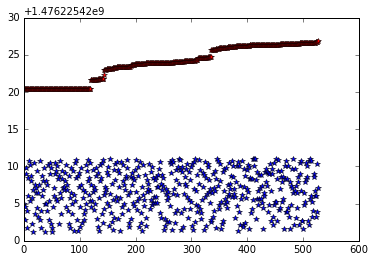

In [259]:
print 'Trajectory Read:', SparkExps['DataInit'][53]
print 'Scheduling Delay:', SparkExps['appData'][53]['SchedulerDelay'].mean()/1000
print 'Task REW:',(SparkExps['appData'][53]['Runtime']+SparkExps['appData'][53]['DeserializeTime']+SparkExps['appData'][53]['ResultSerialization']).mean()/1000
print 'Total Task Life:',((SparkExps['appData'][53]['FinishTime'] - SparkExps['appData'][53]['LaunchTime']).mean()/1000)
print ''
print  'Read + Task Life:',(SparkExps['DataInit'][53] + \
      ((SparkExps['appData'][53]['FinishTime'][284]-SparkExps['appData'][53]['LaunchTime'][346]).mean()/1000))
print 'Spark Script Time - (Read+Task Life):',SparkExps['TotalTime'][53]-(SparkExps['DataInit'][53] + \
      ((SparkExps['appData'][53]['FinishTime'][284]-SparkExps['appData'][53]['LaunchTime'][346]).mean()/1000))

print 'RADICAL-Pilot Mean CU:', rp_haus_528_6_long['TotalTime'].mean()

plt.plot(SparkExps['appData'][53]['LaunchTime']/1000,'b*')
plt.plot(SparkExps['appData'][53]['FinishTime']/1000,'r*')

In [172]:
y=np.array([(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[1].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[2].mean(),\
            (spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[3].mean()])


A = np.array(([48555744,21,spco_execution_short_ca[0],294992/21 + 21],
              [48555744,36,spco_execution_short_ca[1],294992/36 + 36],
              [48555744,78,spco_execution_short_ca[2],294992/78 + 78],
              [48555744,136,spco_execution_short_ca[3],294992/136 + 136]))

D = np.linalg.solve(A, y)
print D
a = np.array([48555744,300,spco_execution_short_ca[0],294912/21 + 21])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean(), 'Error:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[0].mean()-test1




[  1.73986914e-07   1.65912569e-02   9.13465024e-01   3.40745254e-04]
Small: Predicted Total Time 300 tasks: 30.6275976993 Actual Mean Total Time: 26.0 Error: -4.62759769929


In [166]:
a = np.array([48555744,300,spco_execution_short_ca[4],294912/300+300])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[4].mean(), 'Error:',SparkExps['TotalTime'][12:15].mean()-test1

a = np.array([48555744,528,spco_execution_short_ca[5],294912/528+528])

test1 = np.inner(a,D)

print 'Small: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',(spco_stageout_short_ca+spco_stagein_short_ca+spco_schedulerdelay_short_ca+spco_execution_short_ca)[5].mean(), 'Error:',SparkExps['TotalTime'][15:18].mean()-test1

Small: Predicted Total Time 300 tasks: 17.0306673126 Actual Mean Total Time: 24.6666666667 Error: 1.96933268741
Small: Predicted Total Time 528 tasks: 20.0541413234 Actual Mean Total Time: 28.0 Error: 1.94585867656


In [150]:
a = np.array([97111488,21,spco_execution_med_ca[0].mean(),294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 21 tasks:',test1,'Actual Mean Total Time:',SparkExps['TotalTime'][18:21].mean(), 'Error:',SparkExps['TotalTime'][18:21].mean()-test1

a = np.array([97111488,36,spco_execution_med_ca[1],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 36 tasks:',test1,'Actual Mean Total Time:',SparkExps['TotalTime'][21:24].mean(), 'Error:',rp_haus_36_24_med['TotalTime'].mean()-test1

a = np.array([97111488,78,spco_execution_med_ca[2],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 78 tasks:',test1,'Actual Mean Total Time:',rp_haus_78_16_med['TotalTime'].mean(), 'Error:',rp_haus_78_16_med['TotalTime'].mean()-test1

a = np.array([97111488,136,spco_execution_med_ca[3],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 136 tasks:',test1,'Actual Mean Total Time:',rp_haus_136_12_med['TotalTime'].mean(), 'Error:',rp_haus_136_12_med['TotalTime'].mean()-test1

a = np.array([97111488,300,spco_execution_med_ca[4],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 300 tasks:',test1,'Actual Mean Total Time:',rp_haus_300_8_med['TotalTime'].mean(), 'Error:',rp_haus_300_8_med['TotalTime'].mean()-test1

a = np.array([97111488,528,spco_execution_med_ca[5],294912])

test1 = np.inner(a,D)

print 'Medium: Predicted Total Time 528 tasks:',test1,'Actual Mean Total Time:',rp_haus_528_6_med['TotalTime'].mean(), 'Error:',rp_haus_528_6_med['TotalTime'].mean()-test1

Medium: Predicted Total Time 21 tasks: 118.819239748 Actual Mean Total Time: 35.3333333333 Error: -83.4859064144
Medium: Predicted Total Time 36 tasks: 108.524012292 Actual Mean Total Time: 22.6666666667 Error: -86.2770602526
Medium: Predicted Total Time 78 tasks: 103.26024404 Actual Mean Total Time: 10.8571666795 Error: -92.4030773608
Medium: Predicted Total Time 136 tasks: 103.924102453 Actual Mean Total Time: 6.88058625833 Error: -97.0435161948
Medium: Predicted Total Time 300 tasks: 109.329720293 Actual Mean Total Time: 3.67618065543 Error: -105.653539637
Medium: Predicted Total Time 528 tasks: 120.853325224 Actual Mean Total Time: 3.23822765489 Error: -117.615097569


### CU Arrival Time Fit

(array([ 0.01313076,  7.66860076]),
 array([ 2.51813803]),
 2,
 array([ 1057.57536549,     1.5317637 ]))

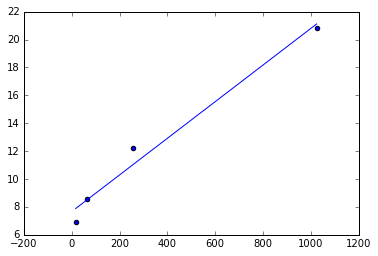

In [86]:
Arrival16 = np.mean([rp_haus_16_32_short_ca_1['StageIn'].max(),rp_haus_16_32_short_ca_2['StageIn'].max(),rp_haus_16_32_short_ca_3['StageIn'].max(),rp_haus_16_32_med_ca_1['StageIn'].max(),rp_haus_16_32_med_ca_2['StageIn'].max(),rp_haus_16_32_med_ca_3['StageIn'].max(),rp_haus_16_32_long_ca_1['StageIn'].max(),rp_haus_16_32_long_ca_2['StageIn'].max(),rp_haus_16_32_long_ca_3['StageIn'].max()])
Arrival64 = np.mean([rp_haus_64_16_short_ca_1['StageIn'].max(),rp_haus_64_16_short_ca_2['StageIn'].max(),rp_haus_64_16_short_ca_3['StageIn'].max(),rp_haus_64_16_med_ca_1['StageIn'].max(),rp_haus_64_16_med_ca_2['StageIn'].max(),rp_haus_64_16_med_ca_3['StageIn'].max(),rp_haus_64_16_long_ca_1['StageIn'].max(),rp_haus_64_16_long_ca_2['StageIn'].max(),rp_haus_64_16_long_ca_3['StageIn'].max()])
Arrival256 = np.mean([rp_haus_256_8_short_ca_1['StageIn'].max(),rp_haus_256_8_short_ca_2['StageIn'].max(),rp_haus_256_8_short_ca_3['StageIn'].max(),rp_haus_256_8_med_ca_1['StageIn'].max(),rp_haus_256_8_med_ca_2['StageIn'].max(),rp_haus_256_8_med_ca_3['StageIn'].max(),rp_haus_256_8_long_ca_1['StageIn'].max(),rp_haus_256_8_long_ca_2['StageIn'].max(),rp_haus_256_8_long_ca_3['StageIn'].max()])
Arrival1024 = np.mean([rp_haus_1024_4_short_ca_1['StageIn'].max(),rp_haus_1024_4_short_ca_2['StageIn'].max(),rp_haus_1024_4_short_ca_3['StageIn'].max(),rp_haus_1024_4_med_ca_1['StageIn'].max(),rp_haus_1024_4_med_ca_2['StageIn'].max(),rp_haus_1024_4_med_ca_3['StageIn'].max(),rp_haus_1024_4_long_ca_1['StageIn'].max(),rp_haus_1024_4_long_ca_2['StageIn'].max(),rp_haus_1024_4_long_ca_3['StageIn'].max()])

ydata = np.array([Arrival16,Arrival64,Arrival256,Arrival1024])
xdata = np.array([16,64,256,1024])

plt.scatter(xdata,ydata)

A2=np.vstack([xdata, np.ones((len(xdata),))]).T
b3=np.linalg.lstsq(A2,ydata)
plt.plot(xdata,b3[0][0]*xdata+b3[0][1])
b3